In [52]:
import os
import pickle
from inspect import signature

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

import missingno as msno
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# load custom functions
os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
#  os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# source: https://stackoverflow.com/a/28073228/4463701

<h1><center>Entity Matching for Online Marketplaces</center></h1>
<h2><center>Applying Machine Learning to Product Matching</center></h2>
<h3><center>Kyle Gilde</center></h3>
<h4><center>5/14/2019</center></h4>







In [2]:
# Load Data
# DATA_DIRECTORY = '//files/share/goods/OI Team'
ORIGINAL_DIRECTORY = os.getcwd()
DATA_DIRECTORY = 'D:/Documents/Large-Scale Product Matching/'
os.chdir(DATA_DIRECTORY)

# load some feature data
train_test_feature_pairs = pd.read_csv('train_test_feature_pairs.csv')
train_test_offer_features = pd.read_csv('train_test_offer_features.csv')
train_test_normalized_features = pd.read_csv('train_test_normalized_features.csv')
attribute_comp_features_9 = pd.read_csv('attribute_comparison_features-9.csv')

# load some metrics
feature_avgs = pd.read_csv('Output Metrics - Feature Avgs.csv')
model_avgs = pd.read_csv('Output Metrics - Model Avgs.csv')
var_imp_coef = pd.read_csv('logreg-variable-coefficients-importance.csv').set_index('Feature')

In [3]:
# load some models
os.chdir(DATA_DIRECTORY + '/attribute_comparison_features-9')

acf9_models = pickle.load(open('sklearn_models.pkl', 'rb'))
acf9_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))


acf9_rf_class_proba = pickle.load(open('sklearn_class_probabilities.pkl', 'rb'))[2]
acf9_rf_pred = acf9_predictions[2]
acf9_sgb_class_proba = pickle.load(open('sklearn_class_probabilities.pkl', 'rb'))[3]
acf9_sgb_pred = acf9_predictions[3]

# load some models
# os.chdir(DATA_DIRECTORY + '/attribute_comparison_features-7')

# acf7_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))
# acf7_models = pickle.load(open('sklearn_models.pkl', 'rb'))

# # load some models
# os.chdir(DATA_DIRECTORY + '/single_doc_similarity_features-9')

# sd9_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))

# # load some models
# os.chdir(DATA_DIRECTORY + '/single_doc_similarity_features-100')
# sd100_predictions = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))
# sd100_models = pickle.load(open('sklearn_models.pkl', 'rb'))


In [4]:
# constancts
SHORT_TEXT_FEATURES = ['gtin', 'mpn', 'sku', 'identifier', 'brand', 'manufacturer']
MEDIUM_LONG_TEXT_FEATURES = ['name', 'description']
OTHER_FEATURES = ['price']
ALL_FEATURES = SHORT_TEXT_FEATURES + MEDIUM_LONG_TEXT_FEATURES + OTHER_FEATURES
OFFER_ID_COLUMNS = ['offer_id_1', 'offer_id_2']
OFFER_PAIR_COLUMNS = OFFER_ID_COLUMNS + ['filename', 'dataset', 'label', 'file_category']

In [5]:
SAVE_PLOTS = True
PLOT_DIRECTORY = 'C:/Users/kyleg/Entity-Matching-in-Online-Retail/plots'
os.chdir(PLOT_DIRECTORY)

<h2><center>What is Entity Matching (EM)?</center></h2>


<h3><center>2 textual references = same-real world object</center></h3>


<h2><center>Why is EM needed for online marketplaces?</center></h2>


- Offers from multiple vendors


- Create considered product pages

<h3><center>Examples of Offers that Match</center></h3>


In [6]:
test_matches = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                      (train_test_feature_pairs.dataset == 'test')][['file_category', 
                                                                                   'name_1', 
                                                                                   'name_2']]\
.sample(4, random_state=1)

pd.set_option('display.max_colwidth', 0)
h = HTML(test_matches.to_html(index=False))
display(h)

# my_file = open('plots/table_1_matched_offer_pairs.html', 'w')
# my_file.write(h.data)
# my_file.close()

file_category,name_1,name_2
shoes,nike sportswear air force 1 07 white,sneakers buty nike air force 1 07 low white 315122 111
computers,323146 b21 bl20p g2 1p xeon 3 06ghz,323146 b21 bl20p xeon 3 06ghz
watches,daniel wellington dapper sheffield rose gold,daniel wellington men s dapper 38mm sheffield rose watch
cameras,canon eos rebel t5i,canon eos rebel t5i 18 135mm is stm digital slr camera kit black


In [53]:
test_ids = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                    (train_test_feature_pairs.dataset == 'test')]\
                [['offer_id_1', 'offer_id_2']]\
                .stack()\
                .unique()

<h2><center>Exploratory Data Analysis</center></h2>

<h3><center>Dataset Origin</center></h3>

WDC Training Dataset and Gold Standard for Large-Scale Product Matching

- Published in December 2018 

- Product-matching benchmark dataset 


(http://webdatacommons.org/largescaleproductcorpus/)

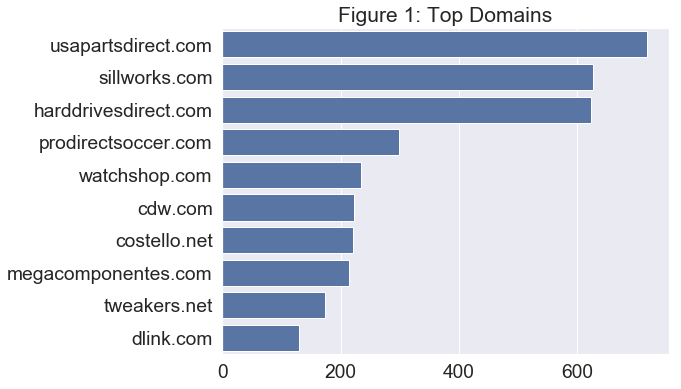

In [54]:
domains = train_test_offer_features.domain.str.replace('www\.|de\.', '')\
    .value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.75)

ax = sns.barplot(x=domains.values, y=domains.index, 
            color="b")\
            .set_title('Figure 1: Top Domains')

<h3><center>Offer Feature Examples</center></h3>

In [9]:
                
train_test_offer_features_only = train_test_offer_features[ALL_FEATURES]
test_offer_features_only = train_test_offer_features.loc[train_test_offer_features.offer_id.isin(test_ids), ALL_FEATURES]

display(HTML(train_test_offer_features_only.head(3).to_html(index=False)))


gtin,mpn,sku,identifier,brand,manufacturer,name,description,price
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,155.94
NaN,672631b21,NaN,NaN,hp enterprise,NaN,672631 b21 hp 16gb 1x16gb sdram dimm,hp 16gb 1x16gb dual rank x4 pc3 12800r ddr3 1600 registered cas 11 memory kitpart number s option part 672631 b21 hp smartbuy part 672631 s21 spare part 684031 001 assembly part 672612 081,155.94
NaN,NaN,NaN,NaN,NaN,hp,hp 16gb ddr3 sdram memory module 16 gb 1 x 16 gb ddr3 sdram 1600 mhz ddr3 1600 pc3 12800 registereddimm,NaN,NaN


<h3><center>Missingness</center></h3>

In [10]:
null_percentages = calculate_percent_nulls(train_test_offer_features_only, print_series=False, return_series=True)
nulls_by_index = train_test_offer_features[null_percentages.index].isnull().T

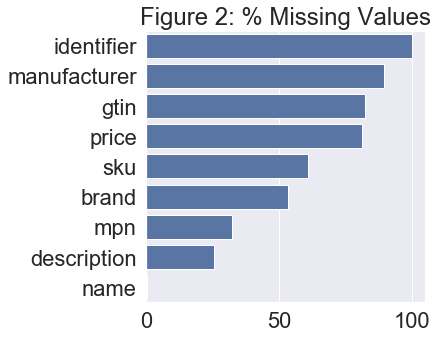

In [59]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=2)

ax = sns.barplot(x=null_percentages.values, 
            y=null_percentages.index, 
            color="b")\
            .set_title('Figure 2: % Missing Values')

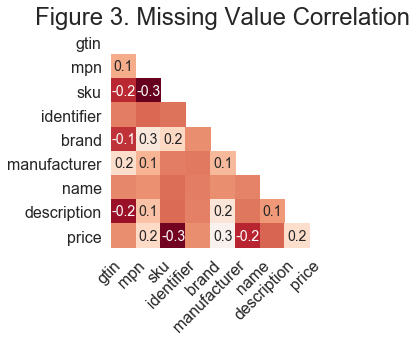

In [66]:
sns.set(font_scale=2)
ax = msno.heatmap(train_test_offer_features_only, figsize=(4, 4)).set_title("Figure 3. Missing Value Correlation")

<h3><center>Offer Features</center></h3>

#### There are 9 offer features that comprise 4 broad feature types.

- 6 are short free-text attributes
    - 4 of them are types of indentifiers: gtin, mpn, sku and a generic identifier
    - 2 of them are the brand and manufacturer

- The offer name is the medium-length text attributes
    
- The description is a longer free-text attribute

- The price is a numeric feature



In [13]:
# count words
medium_long_features = train_test_normalized_features[MEDIUM_LONG_TEXT_FEATURES]
word_counts_df = medium_long_features.apply(count_words, axis=1)

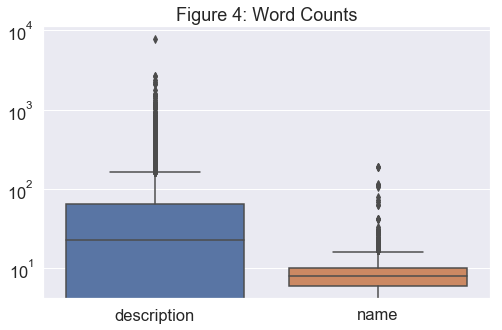

In [63]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = word_counts_df)
ax.set_title('Figure 4: Word Counts')
# ax.xaxis.tick_top()
t = ax.set(yscale='log')

In [15]:
# count chararters for short-text features
short_text_features = train_test_normalized_features[SHORT_TEXT_FEATURES]
char_counts_df = short_text_features.apply(lambda s: s.str.len(), axis=1)

[None]

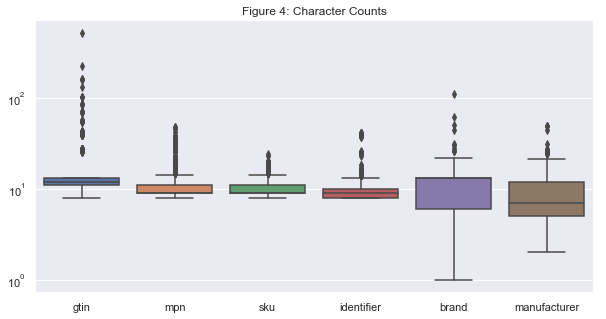

In [60]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1)

ax = sns.boxplot(data = char_counts_df)
ax.set_title('Figure 5: Character Counts')
ax.set(yscale='log')

<h4><center>Brand & Manufacturer</center></h4>

In [17]:
top_values =\
    train_test_normalized_features[['brand', 'manufacturer']]\
        .melt()\
        .dropna().groupby(['variable', 'value'])['value'].agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_counts'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_counts'))\
        .reset_index(drop=True)

top_values['value'] = top_values.value.str.slice(stop=25)

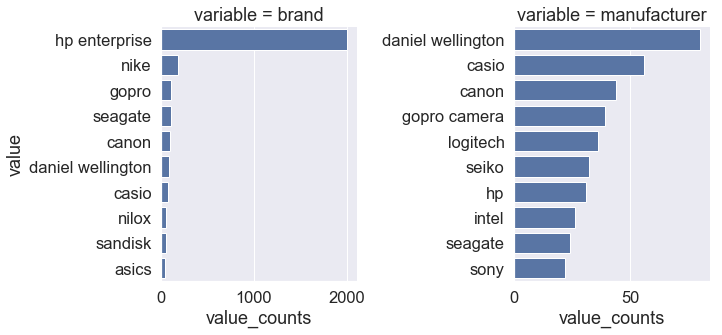

In [64]:
g = sns.FacetGrid(top_values, col="variable", col_wrap=5, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(5)

m = g.map(sns.barplot, 'value_counts', 'value')

<h4><center>Training & Testing Data Characteristics</center></h4>

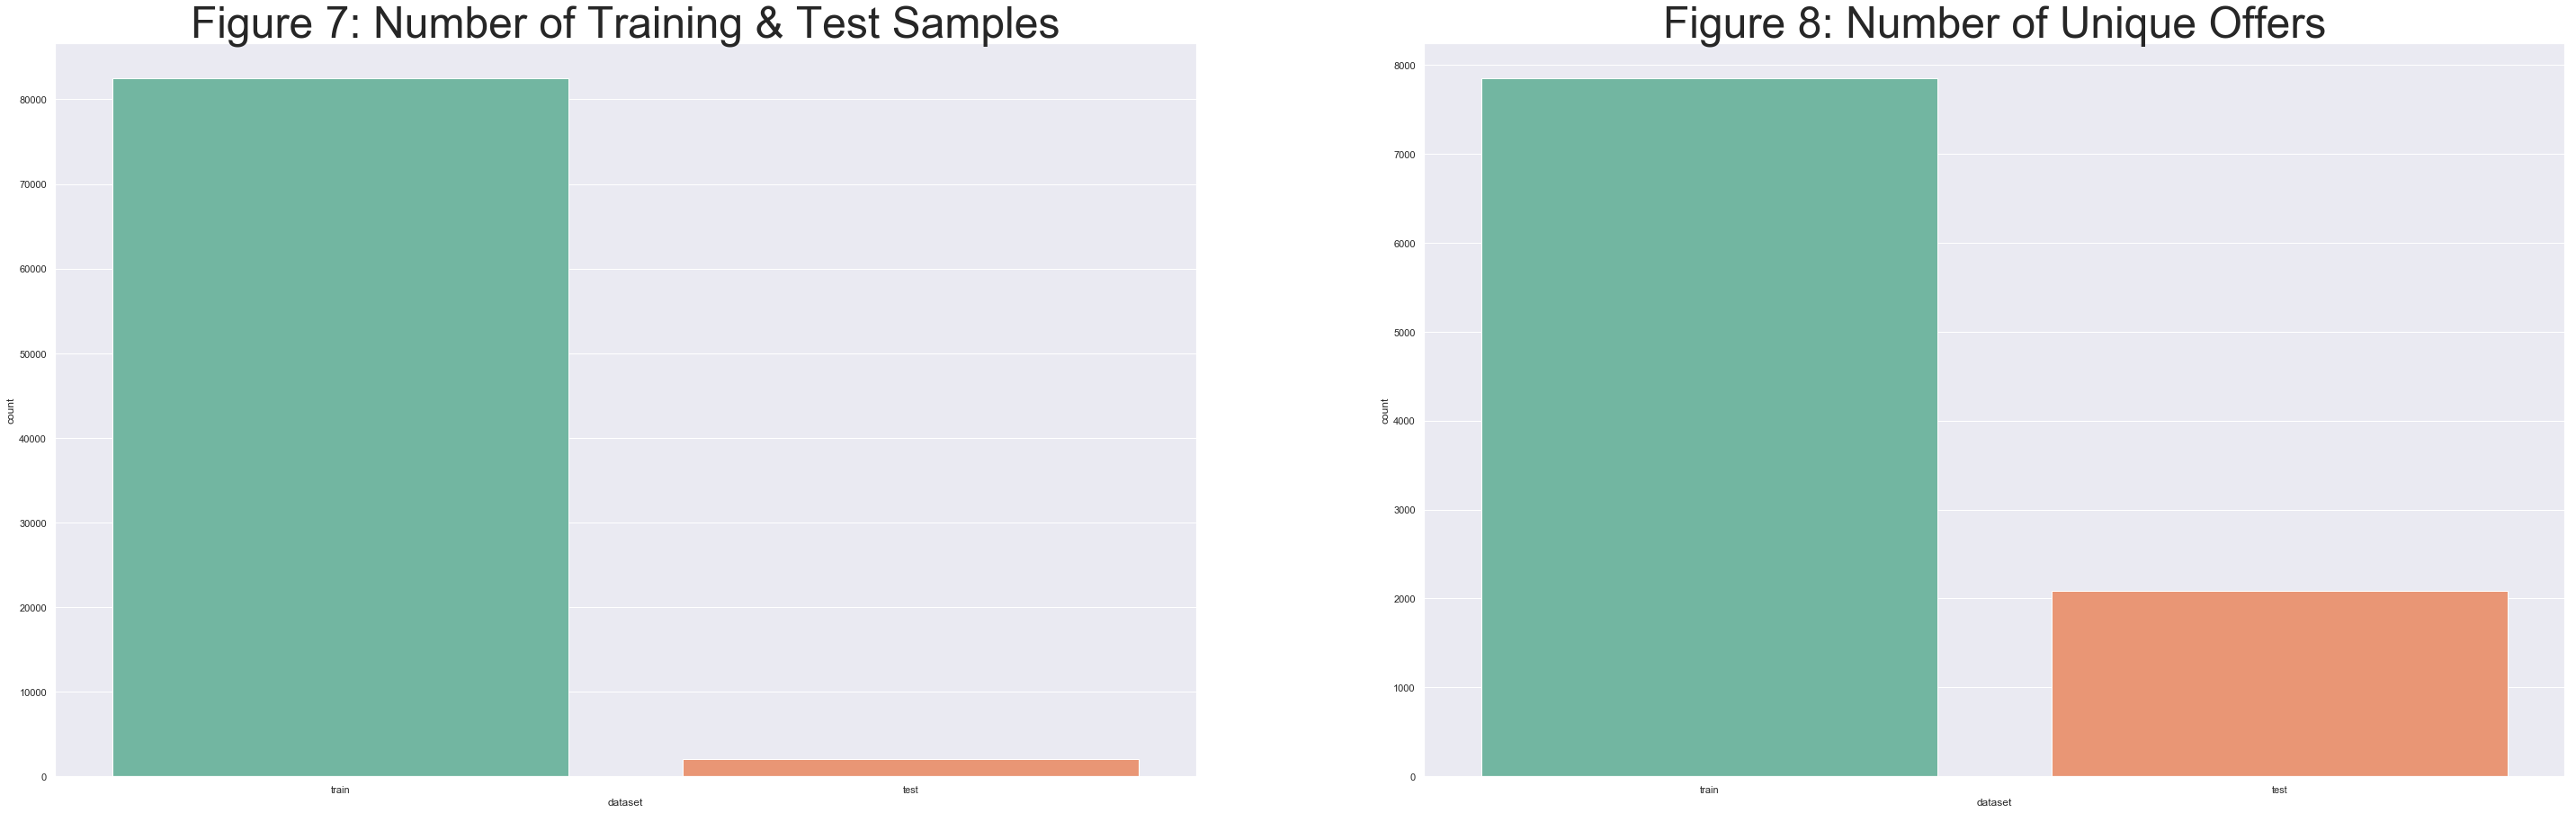

In [19]:
test_train_characteristics = train_test_feature_pairs[['label', 'dataset', 'file_category']]
unique_offers = train_test_feature_pairs.set_index('dataset')[OFFER_ID_COLUMNS].stack().reset_index().drop('level_1', axis=1).drop_duplicates()

fig, axes = plt.subplots(ncols=2, figsize=(50, 15), sharey=False) 


# plt.rcParams.update({'font.size': 35})
# st = fig.suptitle("Training and Testing Dataset Characteristics: Part 1")

sns.set(font_scale=4)

sns.countplot(x='dataset', 
              data=test_train_characteristics, 
              palette=sns.color_palette("Set2"), 
              ax=axes[0])\
            .set_title('Figure 7: Number of Training & Test Samples')

ax1 = sns.countplot(x='dataset', 
              data=unique_offers, 
              palette=sns.color_palette("Set2"), 
              ax=axes[1])\
            .set_title('Figure 8: Number of Unique Offers')

if SAVE_PLOTS: plt.savefig('fig-07-08-sample-offers.png', bbox_inches = "tight")

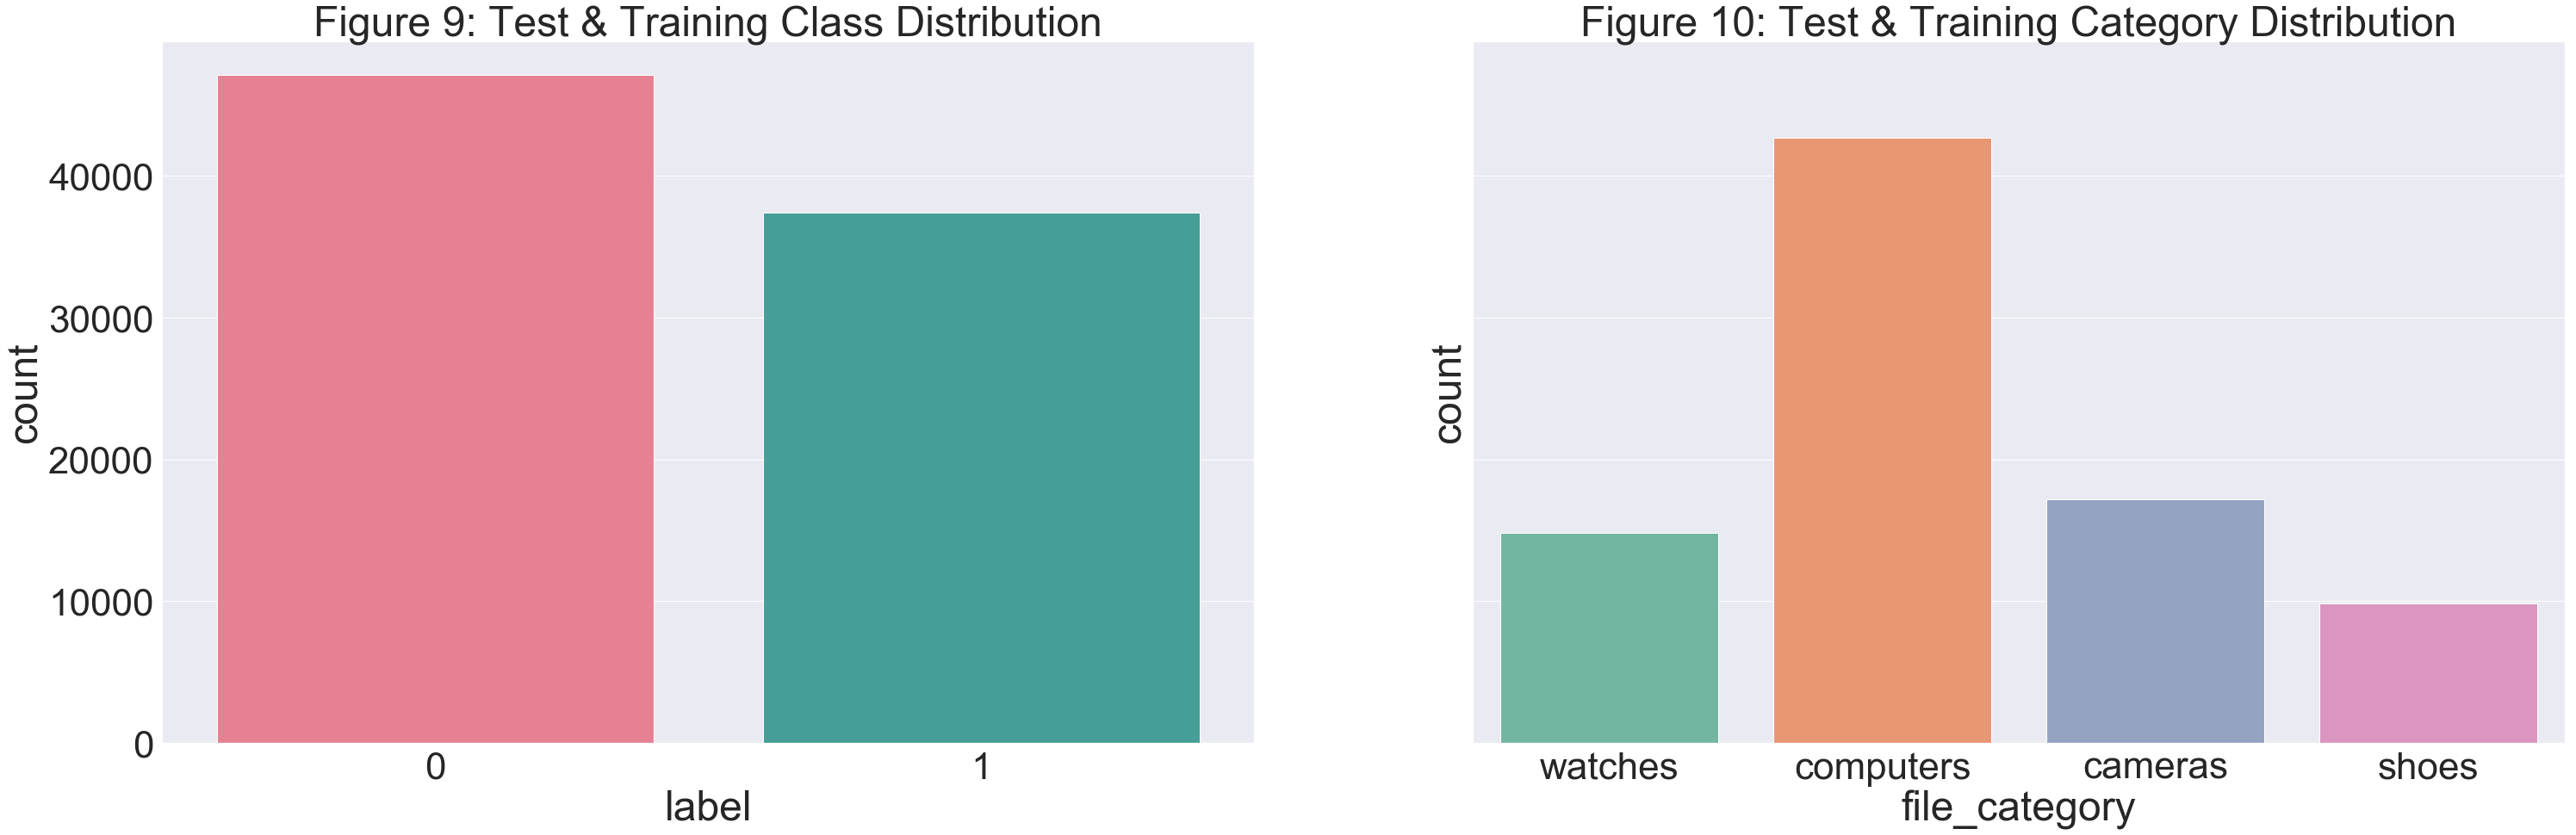

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(50, 15), sharey=True) 


# plt.rcParams.update({'font.size': 35})
# st = fig.suptitle("Training and Testing Dataset Characteristics: Part 2")

sns.set(font_scale=4)
sns.countplot(x='label', 
              data=test_train_characteristics, 
              palette="husl",
              ax=axes[0])\
            .set_title('Figure 9: Test & Training Class Distribution')

ax1 = sns.countplot(x='file_category', 
              data=test_train_characteristics, 
              palette=sns.color_palette("Set2"), 
              ax=axes[1])\
            .set_title('Figure 10: Test & Training Category Distribution')

if SAVE_PLOTS: plt.savefig('fig-09-10-class-categories.png', bbox_inches = "tight")

<h4><center>Testing Data Characteristics</center></h4>


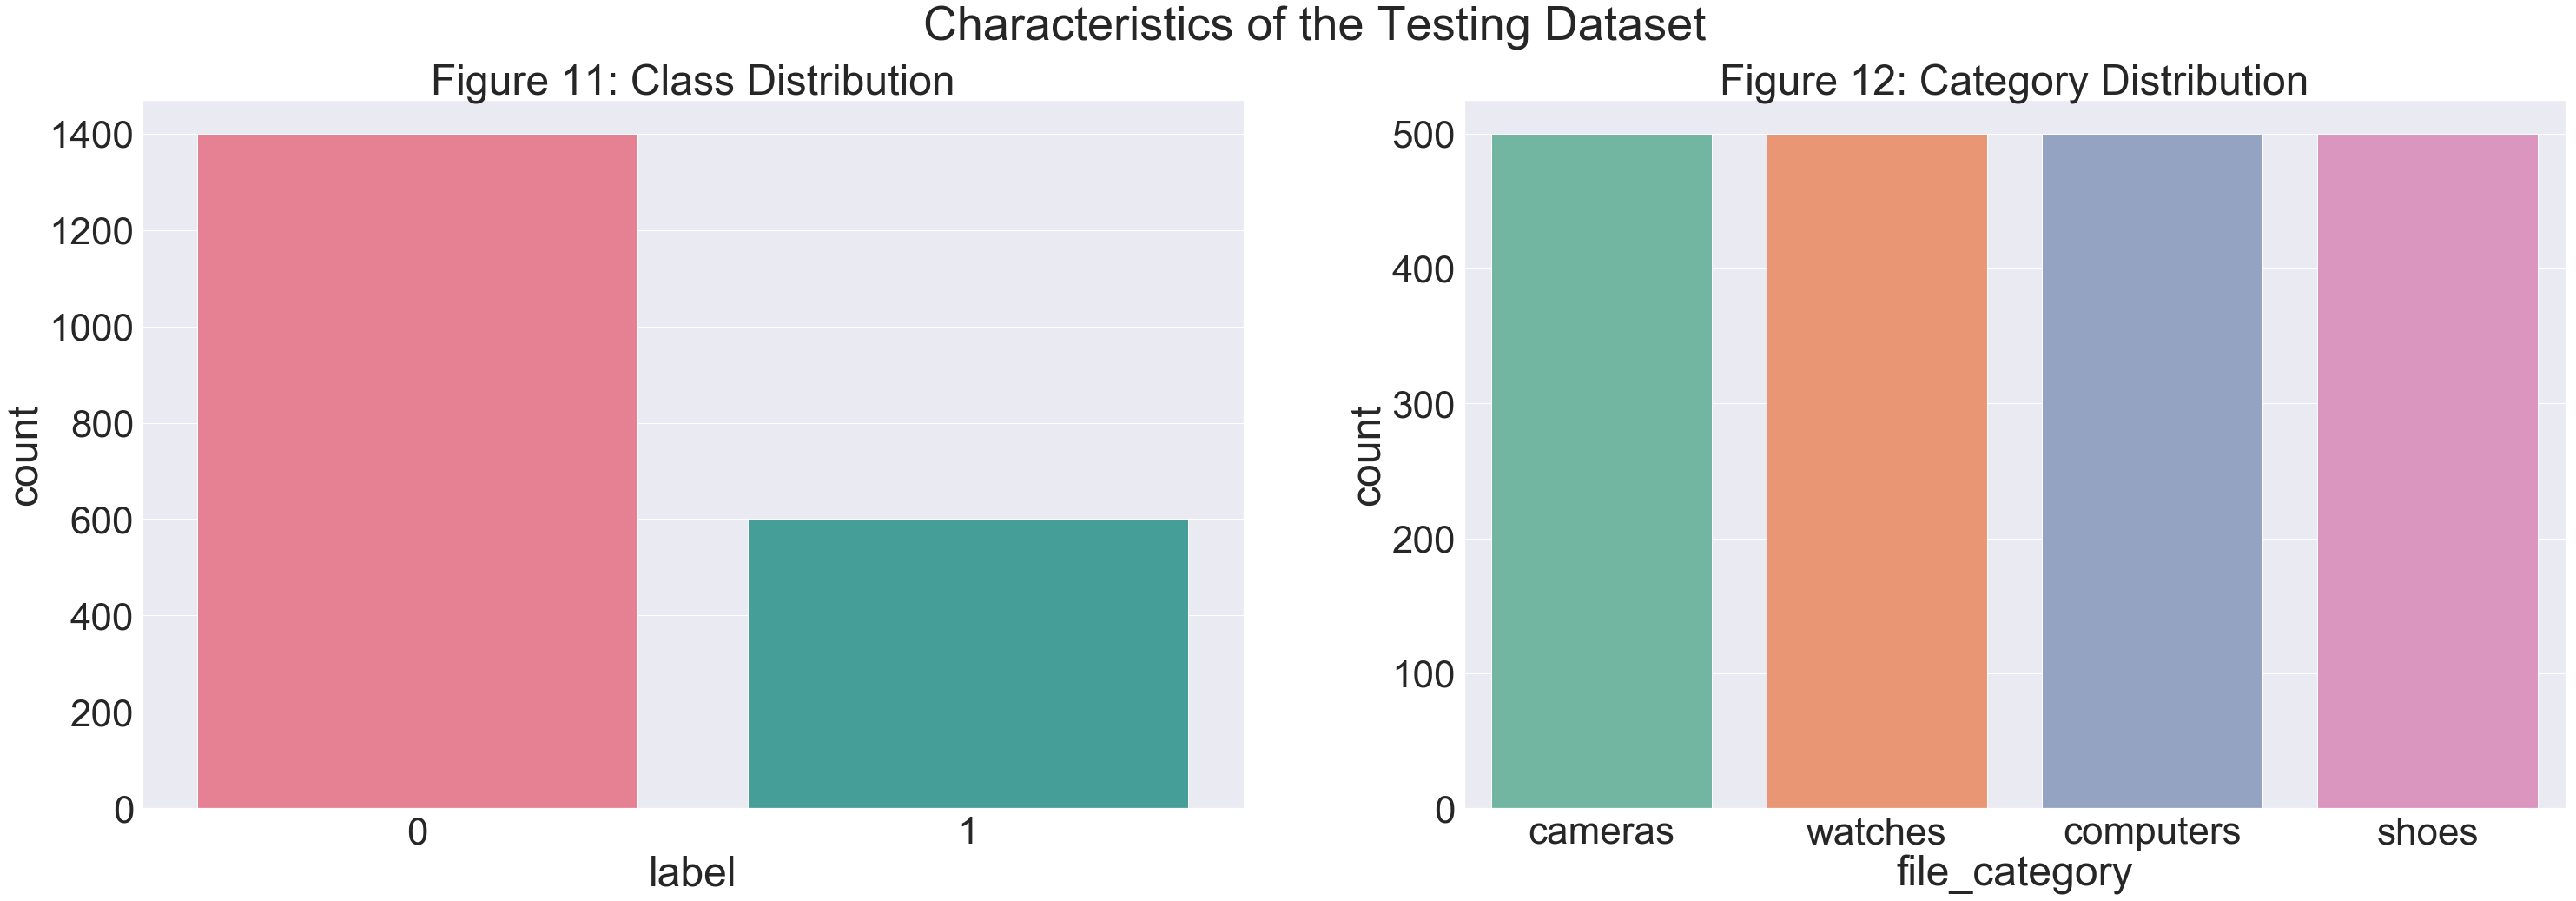

In [21]:
test_characteristics = test_train_characteristics[test_train_characteristics.dataset == 'test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15)) 

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Characteristics of the Testing Dataset")

sns.countplot(x='label', 
              data=test_characteristics, 
              palette="husl",
              ax=axes[0])\
            .set_title('Figure 11: Class Distribution')

sns.countplot(x='file_category', 
              data=test_characteristics, 
              palette=sns.color_palette("Set2"),
              ax=axes[1])\
            .set_title('Figure 12: Category Distribution')

if SAVE_PLOTS: plt.savefig('fig-11-12-test-class-categories.png', bbox_inches = "tight")

<h3><center>Feature Engineering</center></h3>

1. Attribute Comparison Features: Measured the similarity between each offer pair's attribute values

    a. Levenshtein distance
    
    b. Bag-of-words & cosine similarity
    


2. Single Document Features
    
    a. Concatenated all features into a single string
    
    b. Encoded the attributes using TF-IDF bag-of-words
    
    c. Reduced the dimensionality using truncated SVD
    
    d. Absolute difference between the vectors



<h3><center>Feature Analysis</center></h3>

<center>Individual Effects of Attribute-Comparison Features</center>

<h4><center>Scatter and Density Plots by Class</center></h4>

In [22]:
def hide_current_axis(*args, **kwds):
    """
    hides an axis
    """
    # source: https://stackoverflow.com/a/55834340/4463701
    plt.gca().set_visible(False)

attribute_comp_features_9_feat_label = attribute_comp_features_9[ALL_FEATURES + ['label']]

<Figure size 864x864 with 0 Axes>

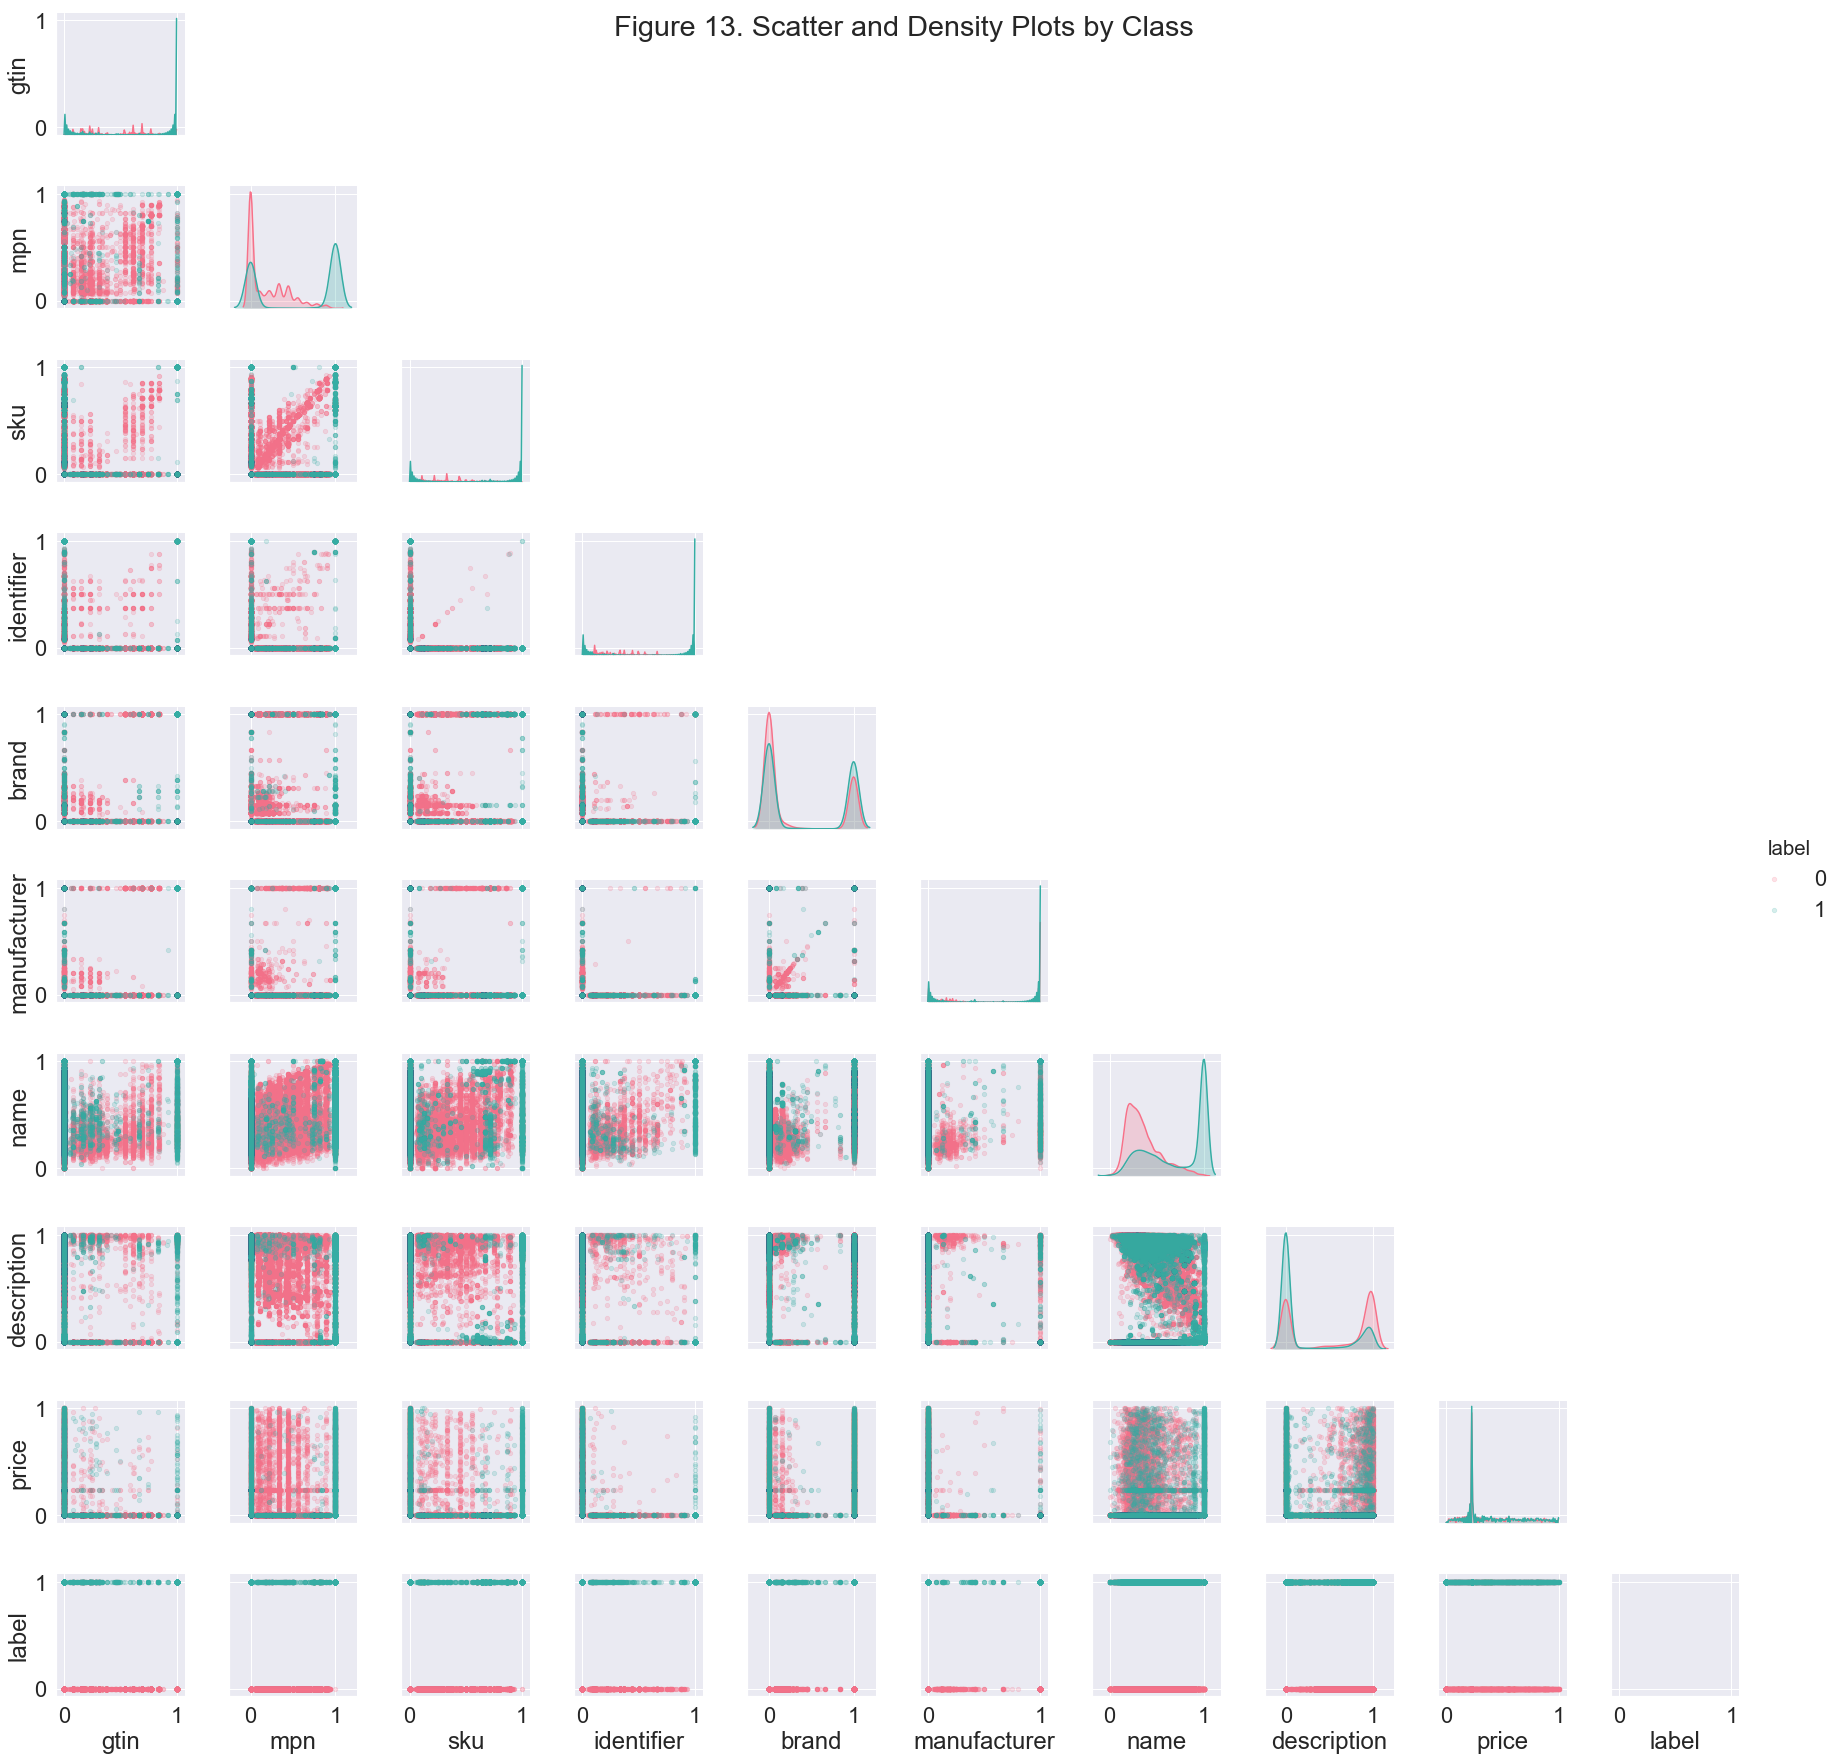

In [23]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=2)
g = sns.pairplot(attribute_comp_features_9_feat_label, #.iloc[:,6:]
                 hue='label', 
                 palette="husl",
                 plot_kws=dict(s=20, edgecolor=None, alpha=.2))
g.fig.suptitle("Figure 13. Scatter and Density Plots by Class")
a = g.map_upper(hide_current_axis)

# plt.setp(g.fig.get_legend().get_texts(), fontsize='22') # for legend text
# plt.setp(g.fig.get_legend().get_title(), fontsize='32') # for legend title

if SAVE_PLOTS: plt.savefig('fig-13-pairs-plot.png', bbox_inches = "tight")

<h4><center>Feature Correlation</center></h4>

In [24]:
# get correlations
feature_corr = attribute_comp_features_9.corr()
mask = np.zeros_like(feature_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

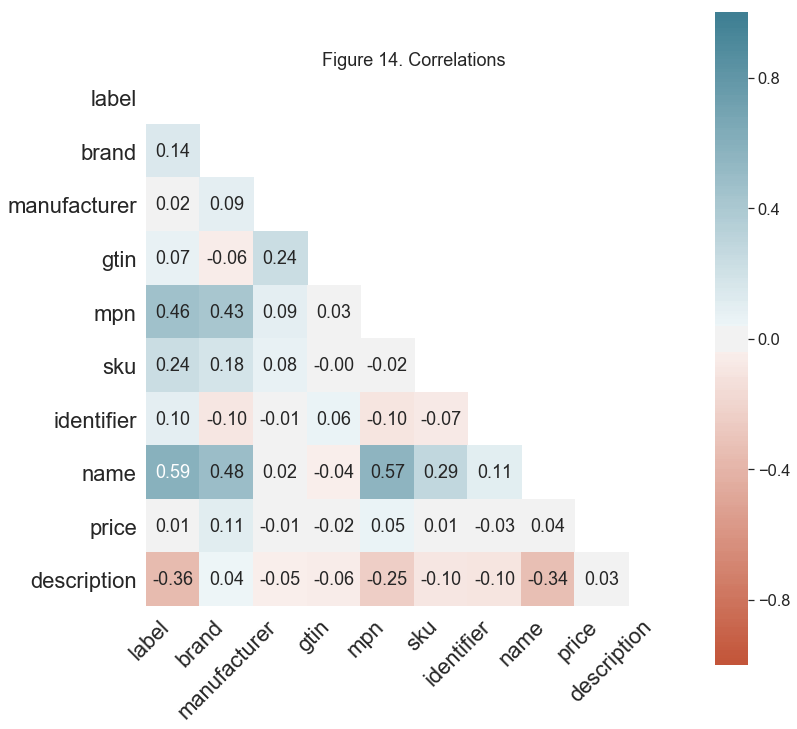

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.heatmap(
    feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt='.2f', 
    mask=mask
).set_title('Figure 14. Correlations')

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.patch.set_visible(False)

# source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

if SAVE_PLOTS: plt.savefig('fig-14-correlations.png', bbox_inches = "tight")

<h4><center>Side-by-Side Boxplots</center></h4>

In [26]:
attribute_comp_features_9_feat_label_melted = pd.melt(attribute_comp_features_9_feat_label, id_vars='label')

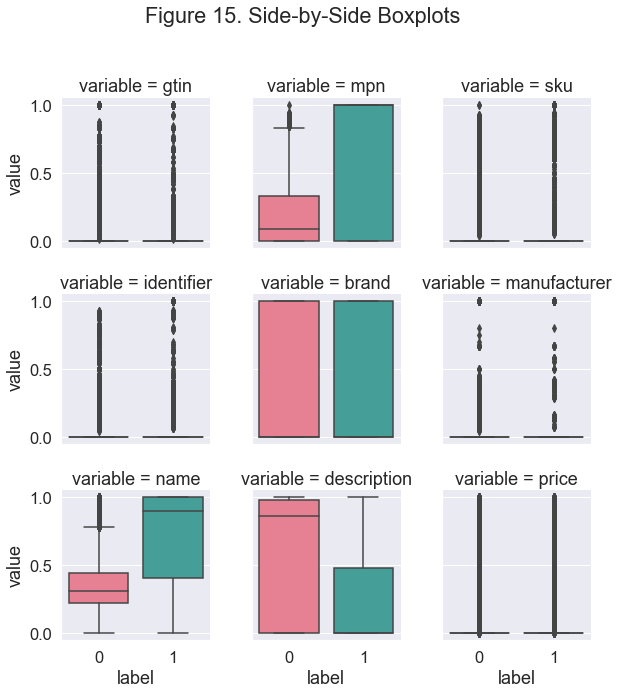

In [27]:
# plt.figure(figsize=(4, 4))
sns.set(font_scale=1.5)

g = sns.catplot(col="variable", 
                y='value',
                x="label",
                data=attribute_comp_features_9_feat_label_melted,
                palette="husl", 
                col_wrap=3,
                kind="box",
                height=3)

t = g.fig.suptitle('Figure 15. Side-by-Side Boxplots', y=1.08)

if SAVE_PLOTS: plt.savefig('fig-15-boxplots.png', bbox_inches = "tight")

<h4><center>Feature Importance</center></h4>

In [28]:
var_imp = var_imp_coef.Overall.sort_values(ascending=False)
var_coef = var_imp_coef.Coefficient.sort_values(ascending=False)

<Figure size 576x1440 with 0 Axes>

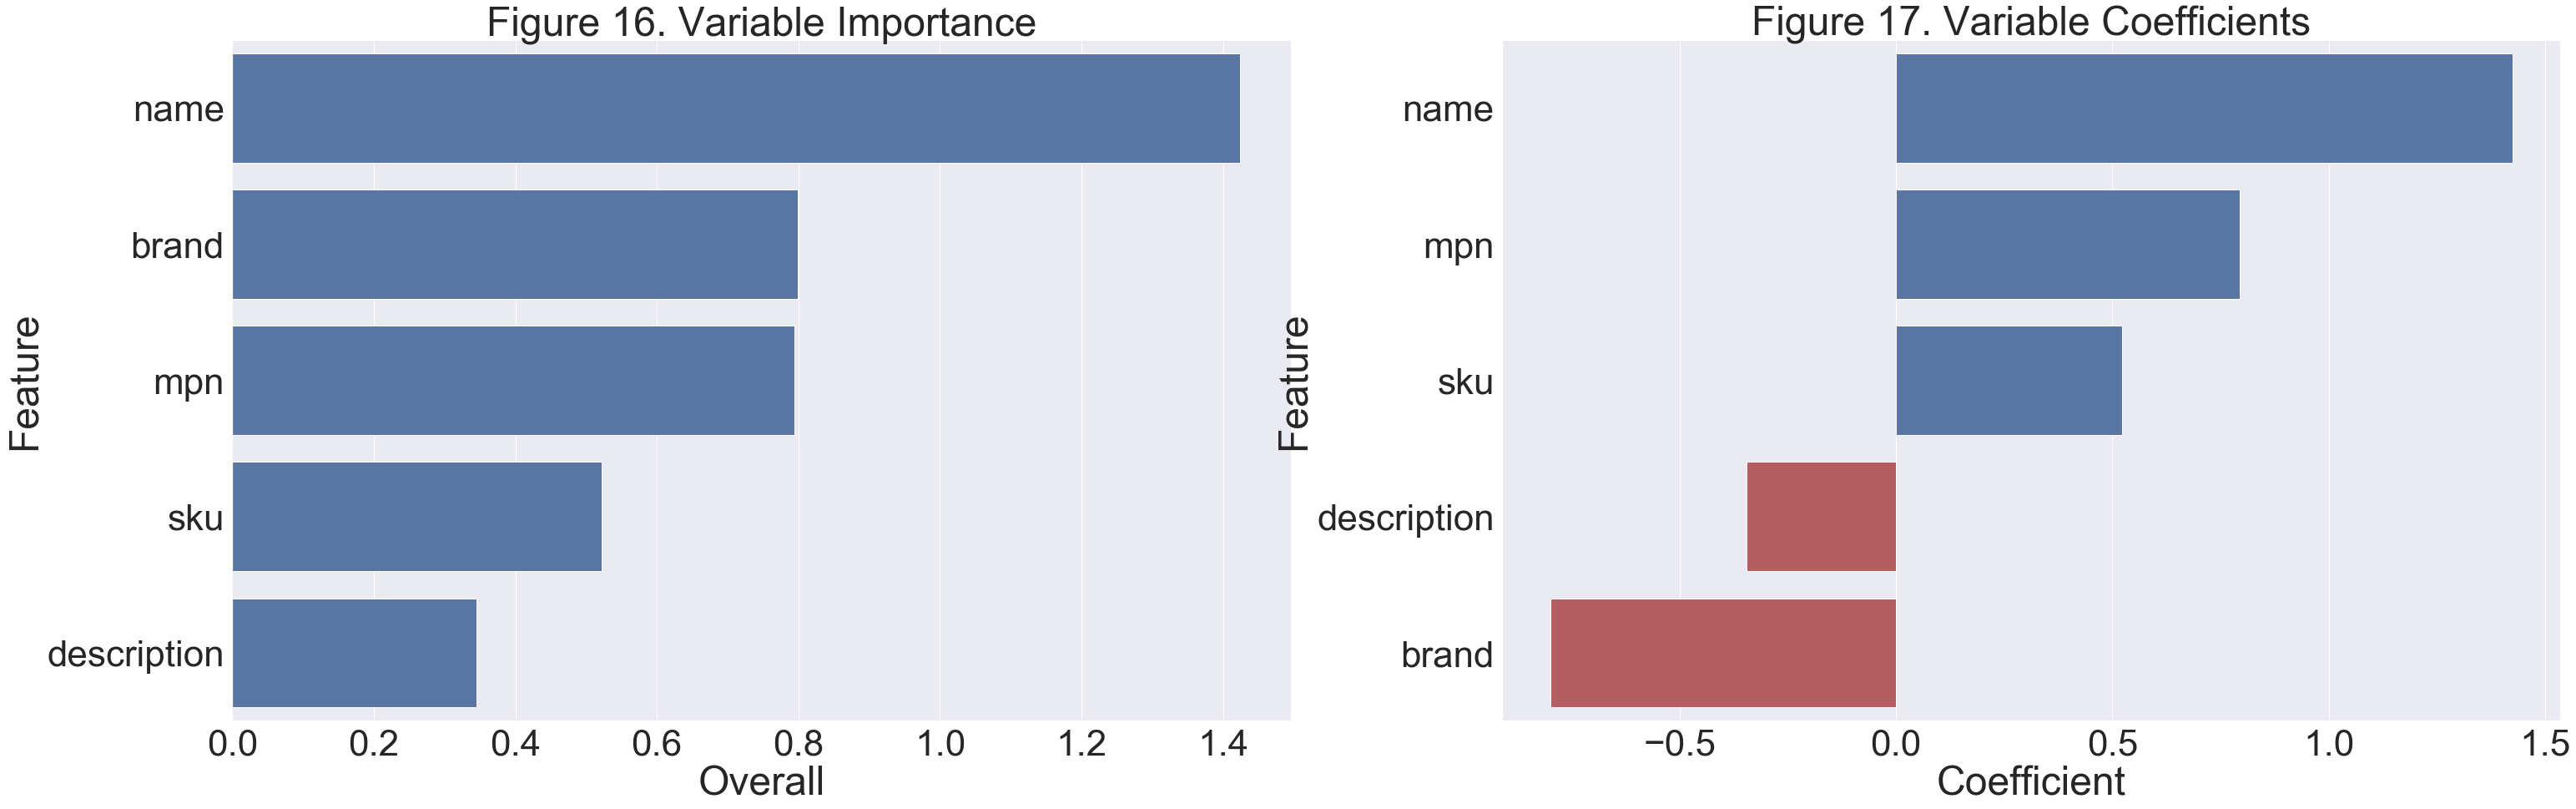

In [29]:
plt.figure(figsize=(8, 20))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))
sns.barplot(x=var_imp, 
            y=var_imp.index, 
            color="b", 
            ax=axes[0])\
            .set_title('Figure 16. Variable Importance')



sns.barplot(x=var_coef, 
            y=var_coef.index, 
            palette=var_coef.apply(lambda x: 'b' if x > 0 else 'r'),
            ax=axes[1])

t2 = axes[1].set_title('Figure 17. Variable Coefficients')

if SAVE_PLOTS: plt.savefig('fig-16-17-logreg-importance.png', bbox_inches = "tight")

In [30]:
offer_pairs_weird_descriptions =\
    attribute_comp_features_9.loc[(attribute_comp_features_9.dataset == 'train') &\
                             (attribute_comp_features_9.label == 1) &\
                             (attribute_comp_features_9.name > .9) &\
                                  (attribute_comp_features_9.description.between(.01, .5))]\
    .set_index(OFFER_PAIR_COLUMNS)['description']

In [31]:
# find examples
weird_description_samples =\
    train_test_feature_pairs\
        .set_index(OFFER_PAIR_COLUMNS)\
        .join(offer_pairs_weird_descriptions, how='inner')\
        .loc[:, ['description_1', 'description_2', 'description']]\
        .reset_index(drop=True)


weird_description_samples['n_tokens_description_1'], weird_description_samples['n_tokens_description_2'] =\
    count_words(weird_description_samples.description_1), count_words(weird_description_samples.description_2)

weird_description_samples['token_delta'] = np.abs(weird_description_samples['n_tokens_description_2'] - weird_description_samples['n_tokens_description_1'])
# weird_description_samples['exact_match'] = weird_description_samples['n_tokens_description_2'] == weird_description_samples['n_tokens_description_1']

weird_description_samples['token_delta_pct'] = 100 * weird_description_samples['token_delta'] / np.minimum(weird_description_samples['n_tokens_description_1'], weird_description_samples['n_tokens_description_2'])

<h4><center>Description Examples</center></h4>

In [32]:
weird_description_example = weird_description_samples.loc[weird_description_samples['token_delta_pct'] > 50, 
                                                            ['description_1', 'description_2']]\
                                                    .iloc[0:3]\
                                                    .drop_duplicates()


weird_description_example.loc[57] = weird_description_example.loc[57].sort_values().values

pd.set_option('display.max_colwidth', 0)
ex = HTML(weird_description_example.to_html(index=False))
display(ex)

if SAVE_PLOTS:    
    my_file = open('description_example.html', 'w')
    my_file.write(ex.data)
    my_file.close()

description_1,description_2
long lasting comfort defines the new nike pegasus 33 which has a new finely tuned outsole that delivers a smooth snappy ride a cushlon midsole provides soft and responsive cushioning while its engineered mesh upper provides lightweight and comfortable support and ventilation as well as impact absorbing cuts to the crash rail that also enhance grip waffle pistons and a radiused heel all combine to give the shoe its renowned ride,long lasting comfort defines the new nike pegasus 33 which has a new finely tuned outsole that delivers a smooth snappy ride a cushlon midsole provides soft and responsive cushioning while its engineered mesh upper provides lightweight and comfortable support and ventilation as well as impact absorbing cuts to the crash rail that also enhance grip waffle pistons and a radiused heel all combine to give the shoe its renowned ride features include horizontal and vertical cuts in the crash rail enhance grip cushlon midsole provides soft yet responsive cushioning flywire cables deliver the ultimate in lockdown engineered mesh upper provides ventilation and support zoom air units in the forefoot and heel provide low profile responsive cushioning weight 8 6oz 244g women s size 8 offset 10mm last mr 10
these pants feature nike tech fleece fabric that helps keep you warm with a relaxed fit that tapers at the cuff to show off your sneakers,these pants feature nike tech fleece fabric that helps keep you warm with a relaxed fit that tapers at the cuff to show off your sneakers features include nike tech fleece fabric gives you warmth without weight max tapered fit is relaxed on top then tapers near the cuff adjustable straps on the sides of the waistband create a custom fit zippered fly with a button closure offers easy on and off


<h3><center>Models</center></h3>

1. Naive Bayes

2. SVM

3. Random Forests

4. Stochastic Gradient Boosting


<h3><center>Results</center></h3>





![](https://github.com/kylegilde/Entity-Matching-in-Online-Retail/blob/master/plots/results-table.PNG?raw=true)

<h4><center>Variable Importance</center></h4>

In [33]:
# get variable importance
rf_acf9 = acf9_models[2].best_estimator_ 
input_feature_order = ['brand', 'manufacturer', 'gtin', 'mpn', 'sku', 'identifier', 'name', 'price', 'description']

var_imp_rf = pd.DataFrame({'feature': input_feature_order,
                           'importance': rf_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

sgb_acf9 = acf9_models[3].best_estimator_ 
var_imp_sgb = pd.DataFrame({'feature': input_feature_order,
                           'importance': sgb_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

<Figure size 720x2880 with 0 Axes>

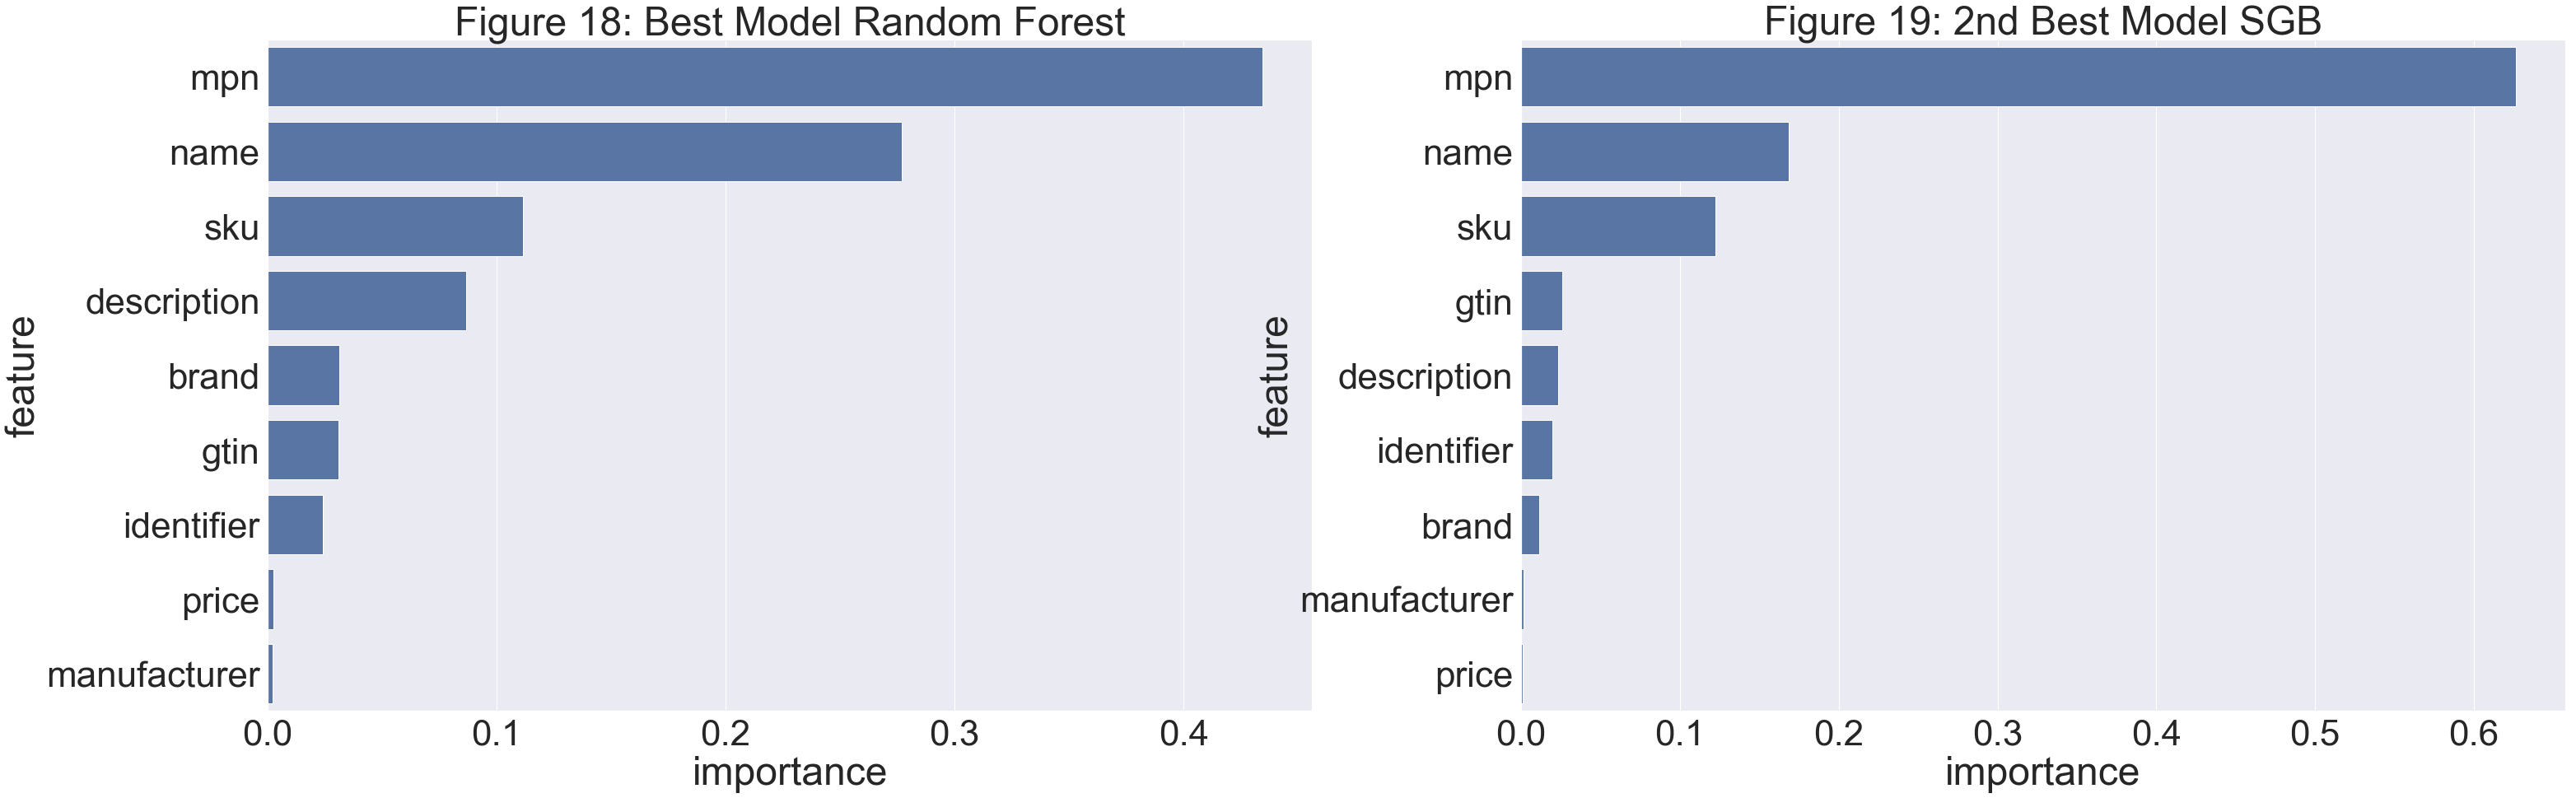

In [34]:
# plot variable importance
plt.figure(figsize=(10, 40))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))

sns.barplot(x=var_imp_rf.importance,
           y=var_imp_rf.index,
           color='b',
           ax=axes[0])\
            .set_title('Figure 18: Best Model Random Forest')

sns.barplot(x=var_imp_sgb.importance,
           y=var_imp_sgb.index,
           color='b',
           ax=axes[1])

t2 = axes[1].set_title('Figure 19: 2nd Best Model SGB')
if SAVE_PLOTS: plt.savefig('fig-18-19-best-importance.png', bbox_inches = "tight")

<h4><center>Precision and Recall: Top 2 Models</center></h4>



In [35]:
# create the curve data
test_labels = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'test', 'label']
precision, recall, thresholds = precision_recall_curve(test_labels, acf9_rf_class_proba[:, 1])
thresholds = np.append(thresholds, 1) 

pr_curve_df = pd.DataFrame({'Precision': precision, 
                            'Recall': recall,
                            'Threshold': thresholds})

pr_curve_df['Delta'] = np.abs(pr_curve_df.Precision - pr_curve_df.Recall)
pr_curve_df_melted = pd.melt(pr_curve_df.iloc[:, :3], id_vars='Threshold')

# AUC
auc_score = auc(pr_curve_df.Recall, pr_curve_df.Precision)

In [36]:
perfect_precision, perfect_recall, equal_scores =\
    pr_curve_df[pr_curve_df.Precision == 1].iloc[0],\
    pr_curve_df[pr_curve_df.Recall == 1].iloc[0],\
    pr_curve_df[pr_curve_df.Delta == np.min(pr_curve_df.Delta)].iloc[0]

# print(perfect_precision, perfect_recall, equal_scores)
thresholds_df = pd.concat([perfect_precision, perfect_recall, equal_scores], 
                          axis=1, 
                          ignore_index=True).T\
    .drop('Delta', axis=1)\
    .round(3)

display(HTML(thresholds_df.to_html(index=False)))

Precision,Recall,Threshold
1.000,0.296,0.999
0.376,1.000,0.041
0.803,0.804,0.571


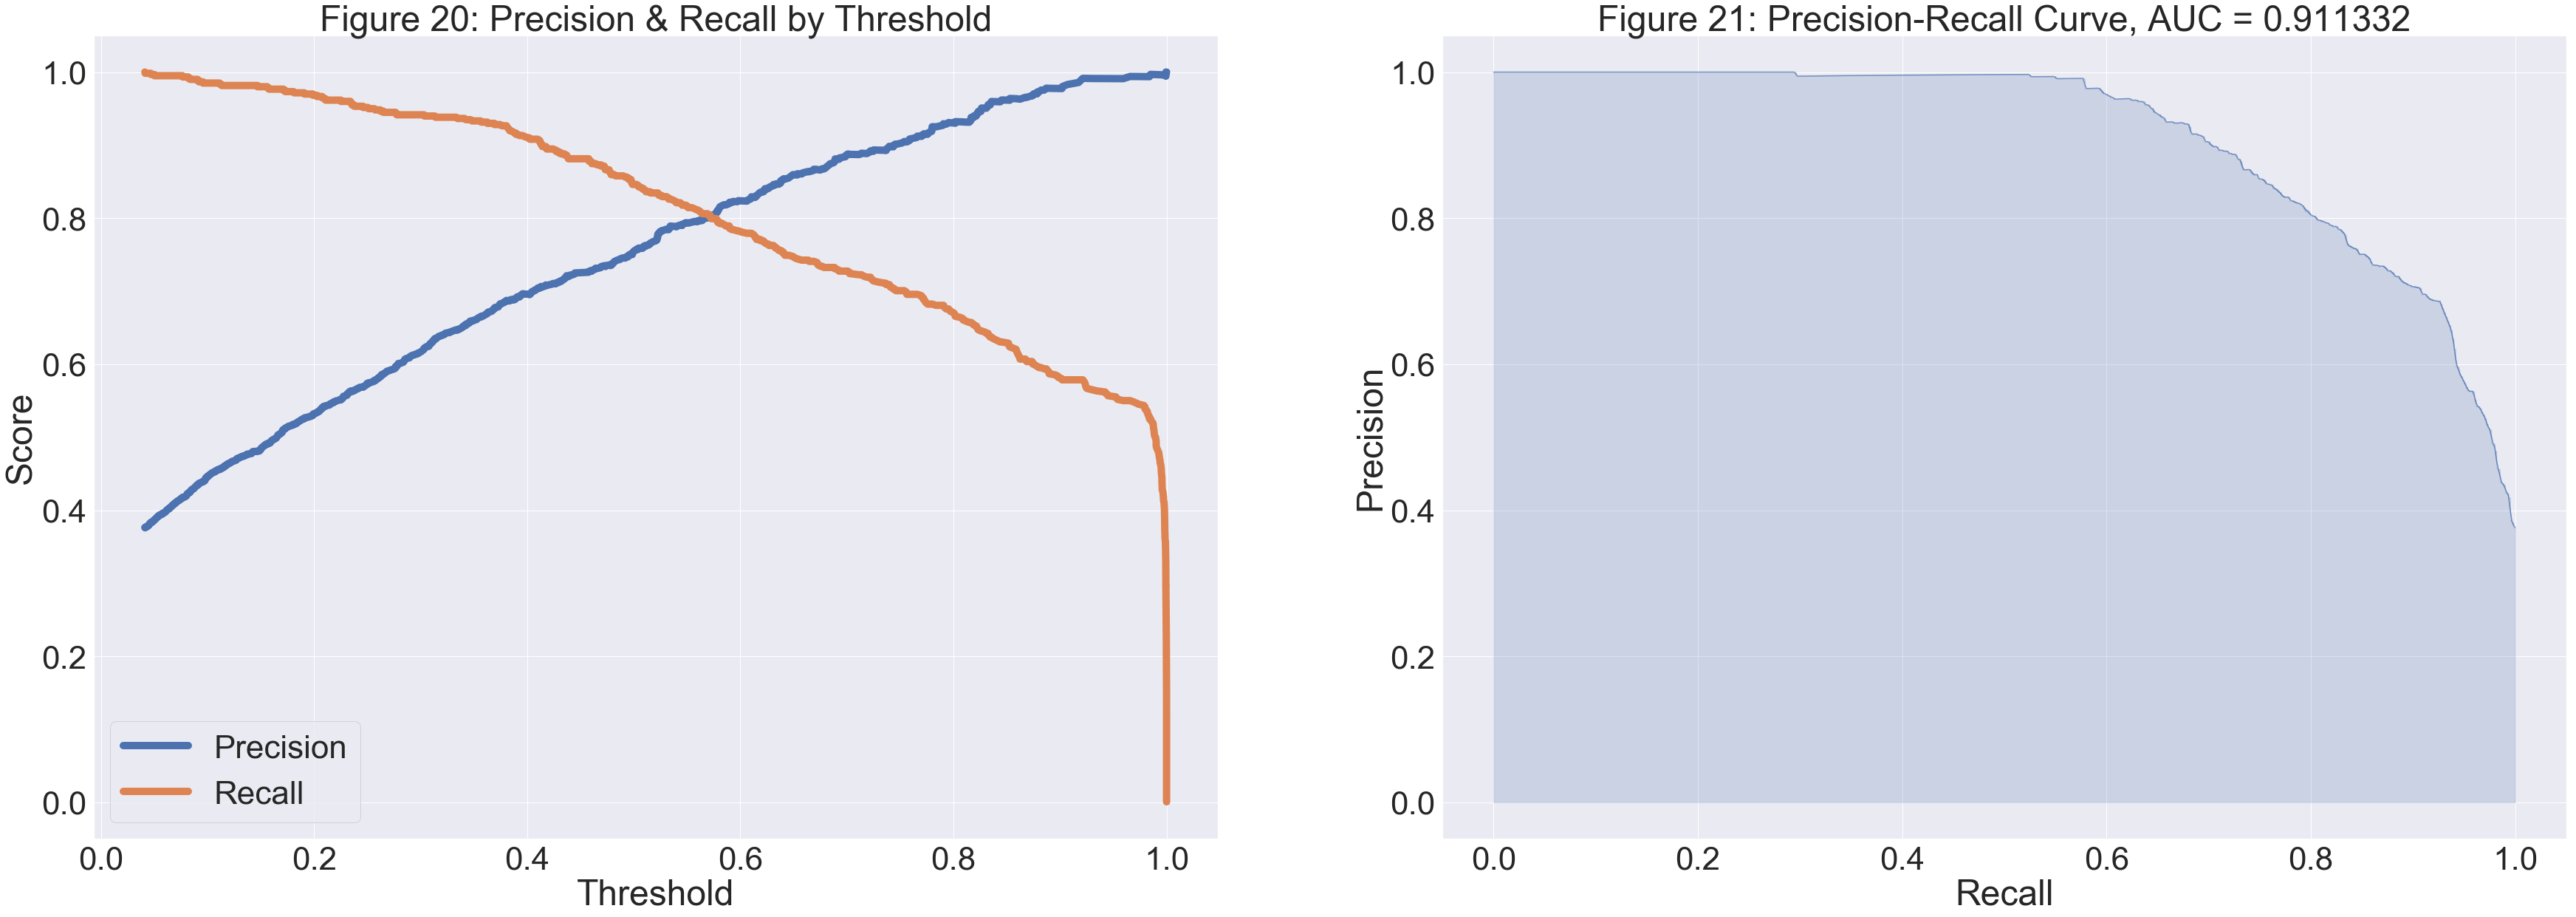

In [37]:
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 20))

# plot 1
sns.lineplot(x='Threshold',
            y='value',
            hue='variable',
            data=pr_curve_df_melted,
            ax=axes[0], 
            linewidth=10)\
            .set_title('Figure 20: Precision & Recall by Threshold')

# plt.axvline(thresholds_df.loc[thresholds_df.Precision==1, 'Threshold'].astype('float'))
axes[0].legend(('Precision', 'Recall'), frameon=True) 
axes[0].set(ylabel='Score')

# plot 2
sns.lineplot(x='Recall',
             y='Precision',
             data=pr_curve_df, 
             alpha=.7,
             ax=axes[1])\
            .set_title('Figure 21: Precision-Recall Curve, AUC = %f' % auc_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

axes[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

if SAVE_PLOTS: plt.savefig('fig-20-21-precsion-recall.png', bbox_inches = "tight")

<h4><center>Performance by Model</center></h4>

In [38]:
# get metrics
model_avgs_melted = pd.melt(model_avgs, id_vars='Model', var_name='Metric', value_name='Score')

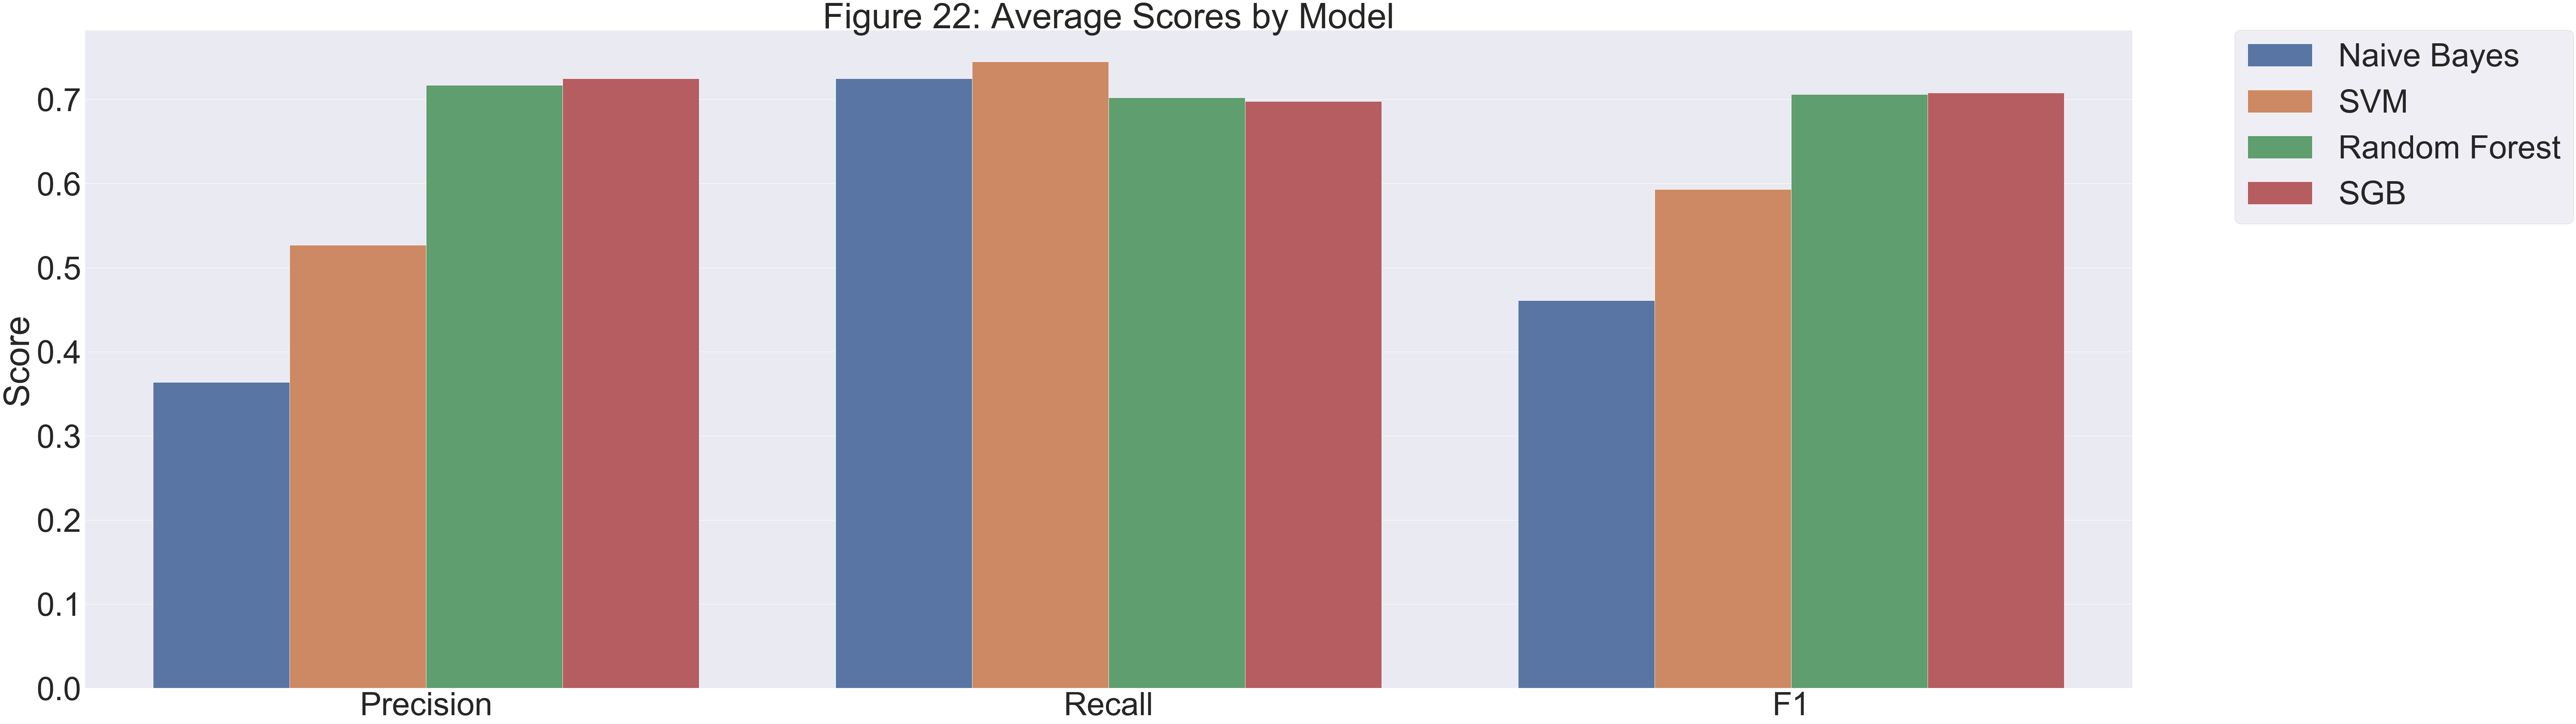

In [39]:
sns.set(font_scale=8)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Model', 
            data=model_avgs_melted).set_title('Figure 22: Average Scores by Model')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

b = plt.xlabel('')
if SAVE_PLOTS: plt.savefig('fig-22-performance-by-model.png', bbox_inches = "tight")

<h4><center>Performance by Feature Set</center></h4>

In [40]:
feature_avgs_melted = pd.melt(feature_avgs, id_vars='Feature Set', var_name='Metric', value_name='Score')


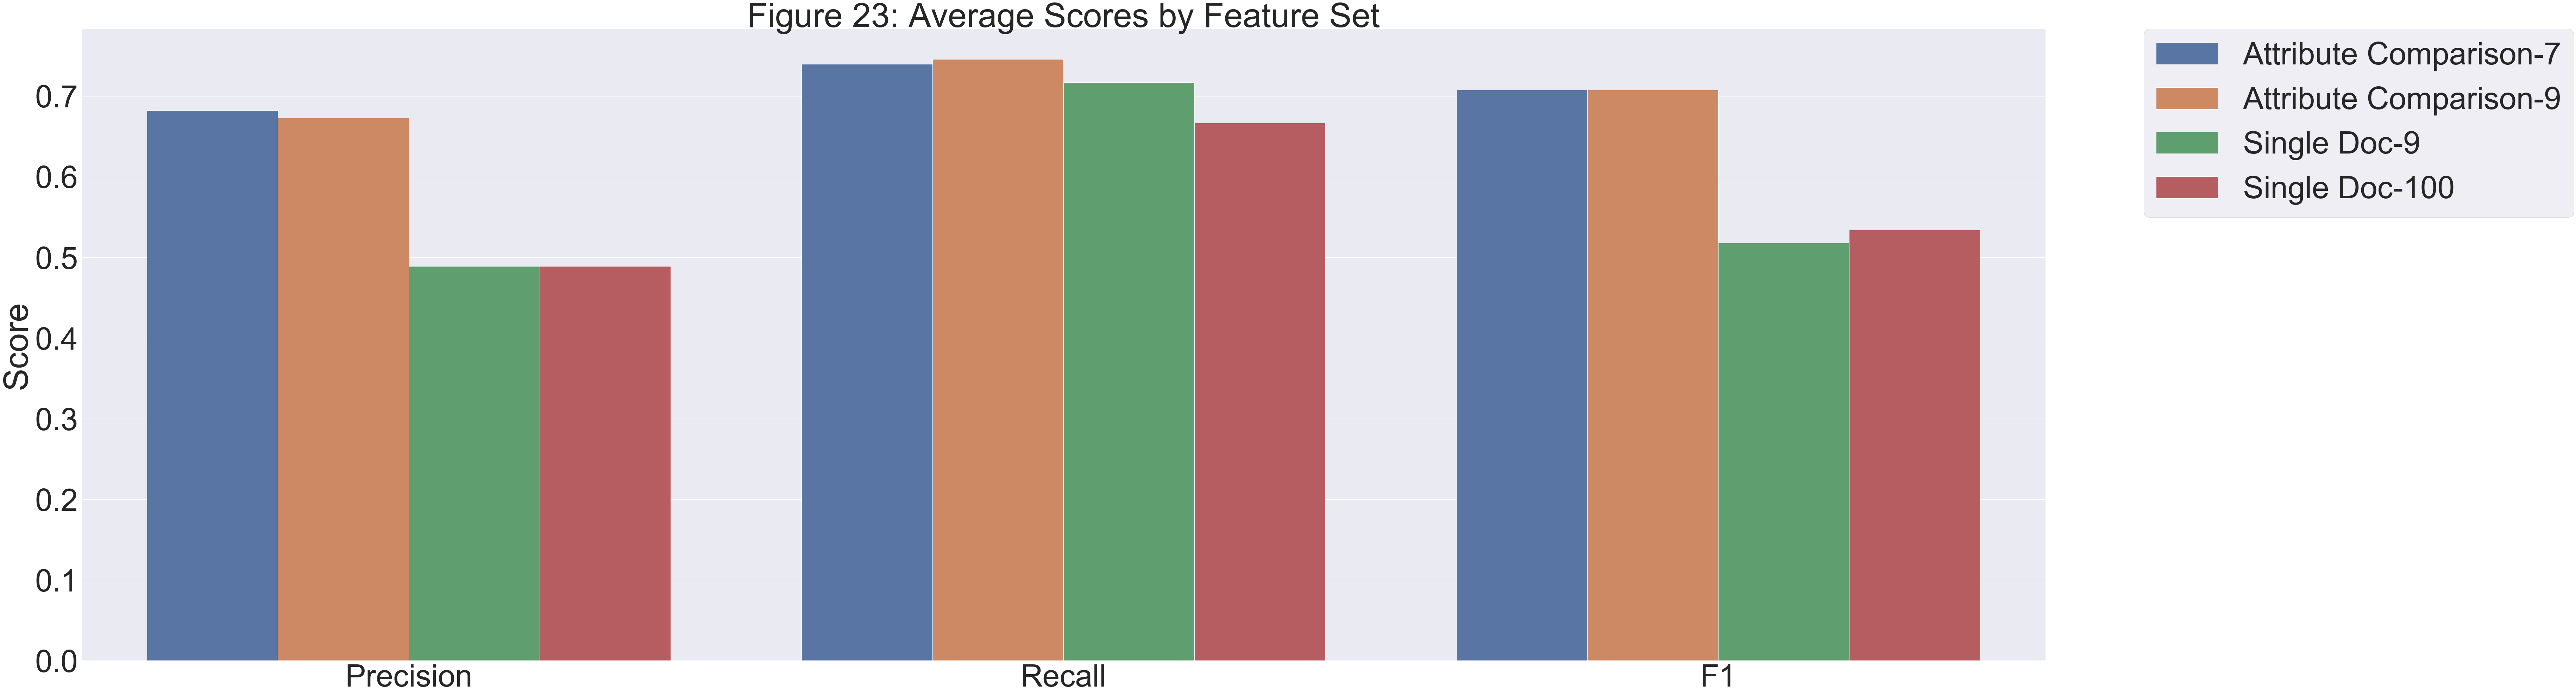

In [43]:
sns.set(font_scale=8)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Feature Set', 
            data=feature_avgs_melted).set_title('Figure 23: Average Scores by Feature Set')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
b = plt.xlabel('')

if SAVE_PLOTS: plt.savefig('fig-23-performance-by-features.png', bbox_inches = "tight")

<h4><center>Performance by Category</center></h4>

In [44]:
test_categories = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'test', 'file_category'].values
train_categories = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'train', 'file_category'].values
unique_categories = pd.Series(train_categories).value_counts().index

all_cat_df = pd.DataFrame({
    'Category': test_categories,
    'Label': test_labels,
    'Prediction': acf9_rf_pred
}).set_index('Category')

cat_score_list = []


for cat in unique_categories:
    cat_df = all_cat_df.loc[cat]
    cat_scores = calculate_scores(cat_df.Label, cat_df.Prediction)
    cat_scores.append(cat)
    cat_score_list.append(cat_scores)
    
cat_score_df = pd.DataFrame(cat_score_list, 
                            columns=['Precision', 'Recall', 'F1', 'Category'])
cat_score_df_melted = pd.melt(cat_score_df, id_vars='Category', var_name='Metric', value_name='Score')

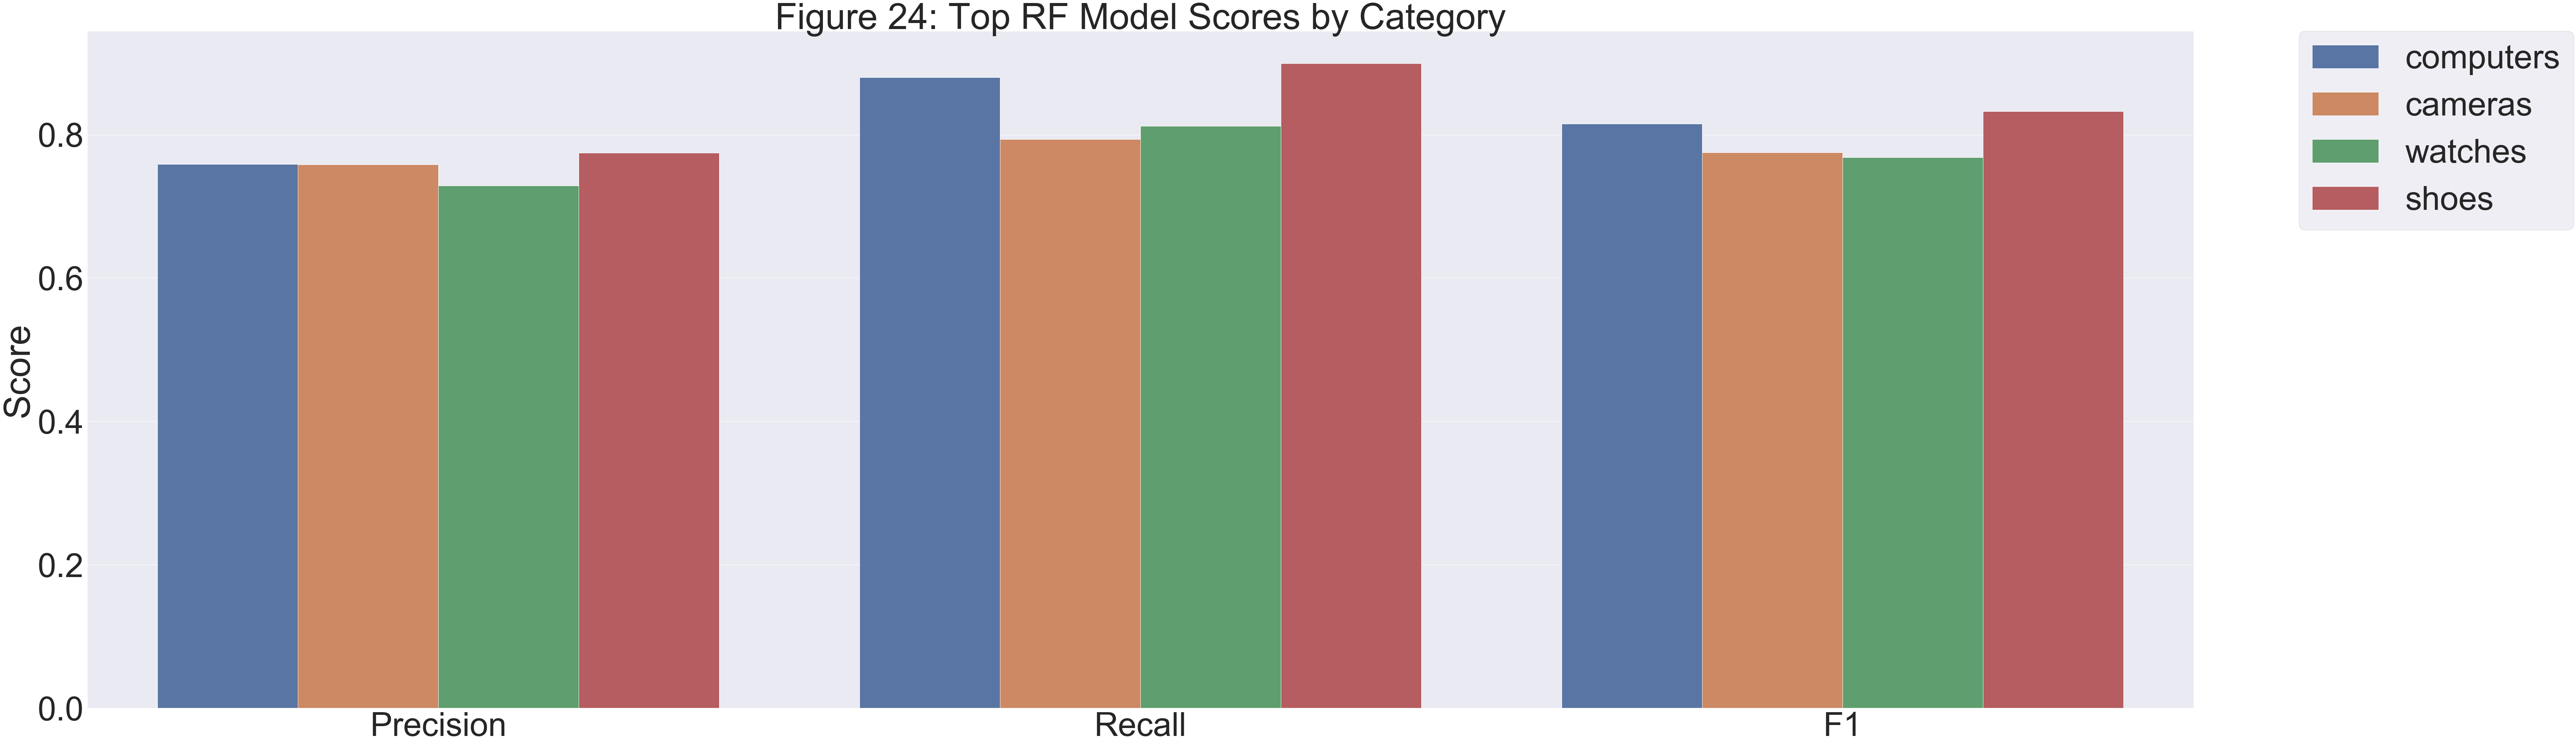

In [45]:
sns.set(font_scale=8)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Category', 
            data=cat_score_df_melted).set_title('Figure 24: Top RF Model Scores by Category')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
b = plt.xlabel('')

if SAVE_PLOTS: plt.savefig('fig-24-performance-by-category.png', bbox_inches = "tight")

#### Why did the Shoes category permform the best?


In [46]:
# null plot
test_feature_pairs_features_only = attribute_comp_features_9.loc[attribute_comp_features_9.dataset=='test', ALL_FEATURES].reset_index(drop=True)
null_counts = test_feature_pairs_features_only.apply(lambda x: np.sum(x == 0), axis=1).values


# mpn plot
category_counts = attribute_comp_features_9[attribute_comp_features_9.dataset=='test'].file_category.value_counts()
category_pct = category_counts / category_counts
categories_not_null_mpn = attribute_comp_features_9.loc[(attribute_comp_features_9.mpn > 0) & (attribute_comp_features_9.dataset=='test'), 'file_category'].value_counts()
categories_not_null_mpn_pct = categories_not_null_mpn / category_counts
# categories_not_null_mpn_pct

,Null Counts
Category,
cameras,6
computers,6
shoes,7
watches,6


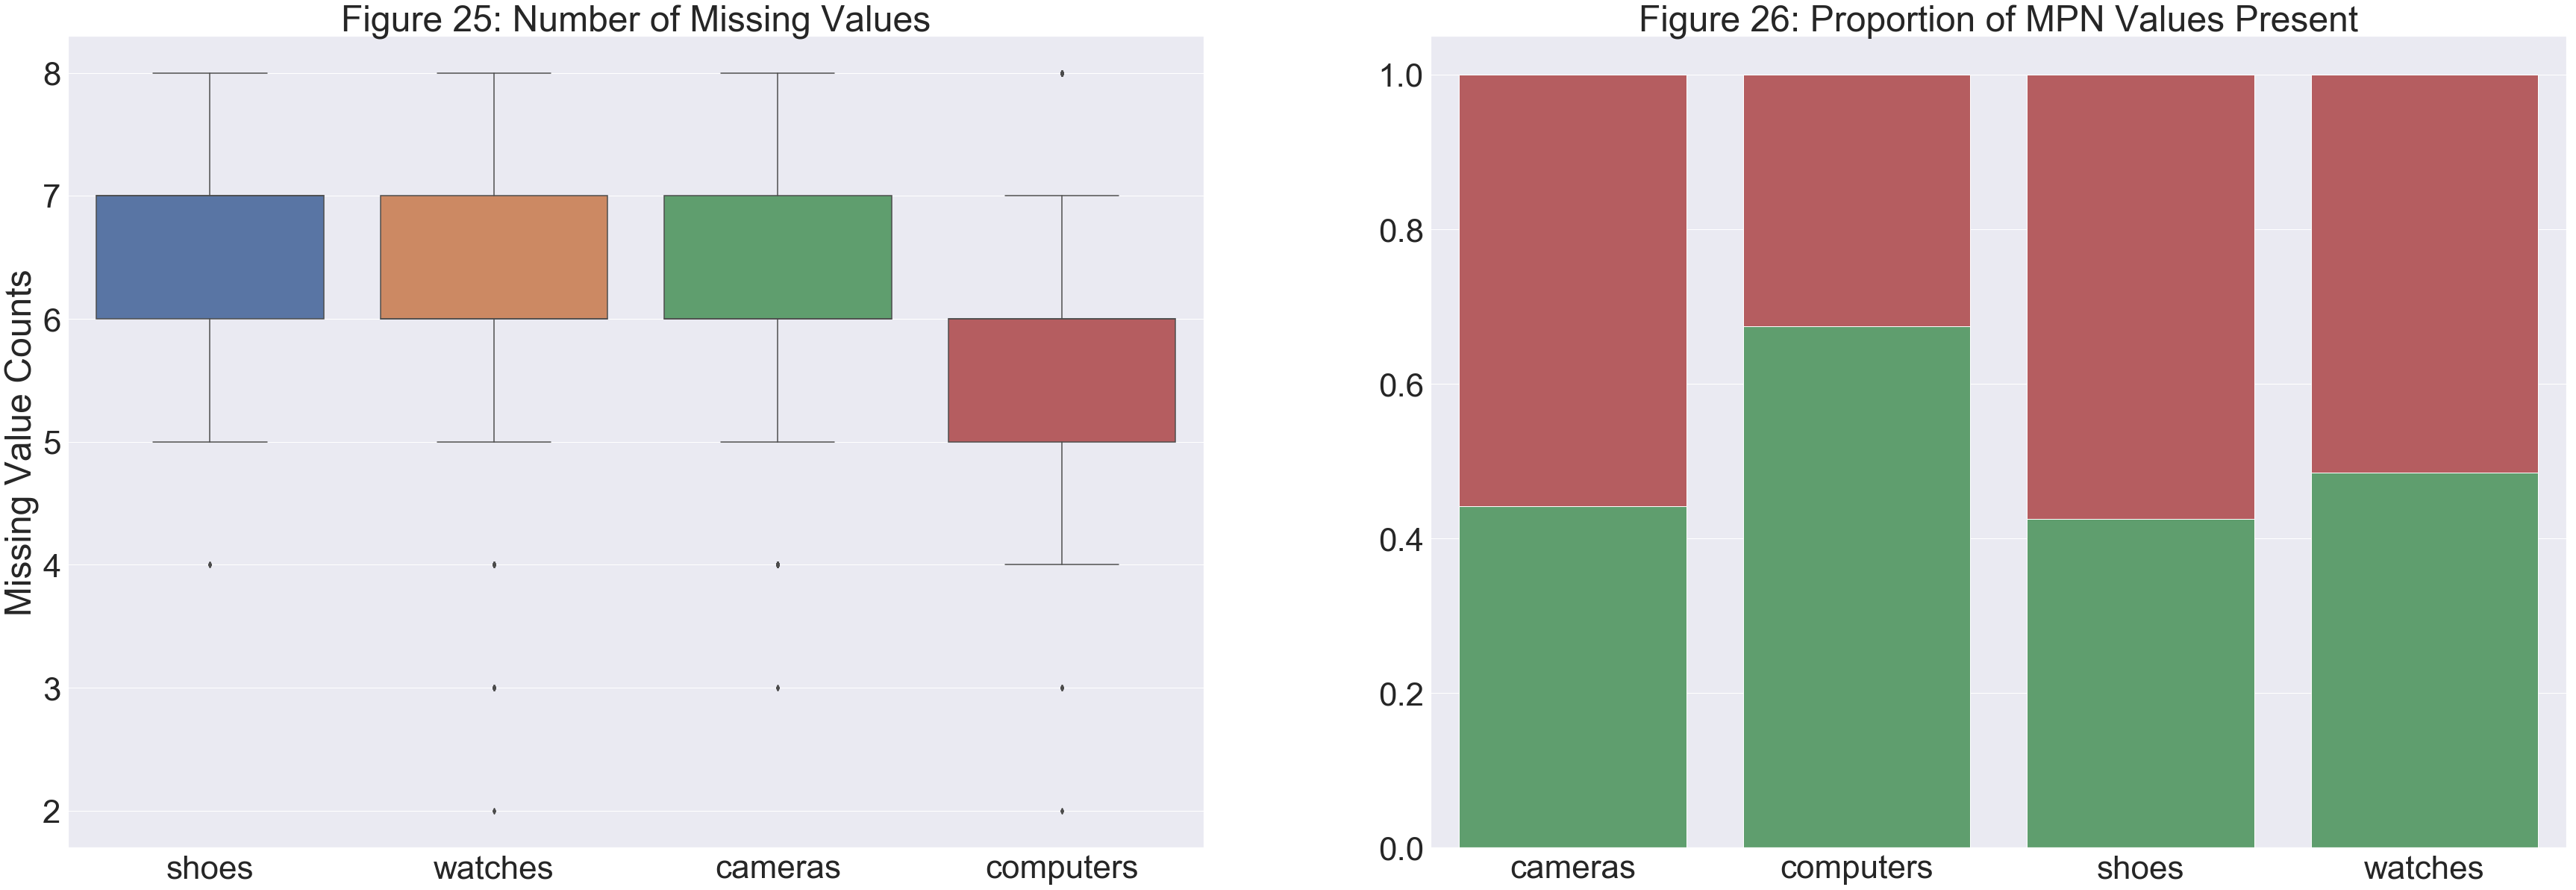

In [47]:
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 20))


# plot 1
ax0 = sns.boxplot(x=test_categories, 
            y=null_counts,
           ax=axes[0])\
            .set_title('Figure 25: Number of Missing Values')

axes[0].set_ylabel('Missing Value Counts')

# plot 2
sns.barplot(x=category_pct.index, 
            y=category_pct,
            color='r',
           ax=axes[1])



sns.barplot(x=categories_not_null_mpn_pct.index, 
            y=categories_not_null_mpn_pct, 
            color='g',
           ax=axes[1])\
            .set_title('Figure 26: Proportion of MPN Values Present')

axes[1].set_ylabel('')

if SAVE_PLOTS: plt.savefig('fig-25-26-shoes.png', bbox_inches = "tight")
    

# pd.DataFrame({'Category': test_categories, 
#               'Null Counts': null_counts})\
#             .groupby('Category')\
#             .median()

In [48]:
# pred_types = pd.DataFrame({'label': test_labels.values,
#                            'pred': acf9_rf_pred})


all_cat_df.loc[(all_cat_df.Label == 1) & (all_cat_df.Prediction == 1), 'Classification Type'] = 'True Positive'
all_cat_df.loc[(all_cat_df.Label == 0) & (all_cat_df.Prediction == 0), 'Classification Type'] = 'True Negative'
all_cat_df.loc[(all_cat_df.Label == 0) & (all_cat_df.Prediction == 1), 'Classification Type'] = 'False Positive'
all_cat_df.loc[(all_cat_df.Label == 1) & (all_cat_df.Prediction == 0), 'Classification Type'] = 'False Negative'
all_cat_df['Null Count'] = null_counts
all_cat_df.sort_values('Classification Type', ascending=True, inplace=True)

# pred_types.groupby('Classification Type').median()

In [49]:
all_cat_df.groupby('Classification Type')['Null Count'].median()

Classification Type
False Negative    7
False Positive    7
True Negative     6
True Positive     7
Name: Null Count, dtype: int64

<h4><center>Effects of the Missingness</center></h4>

Classification Type
False Negative    7
False Positive    7
True Negative     6
True Positive     7
Name: Null Count, dtype: int64

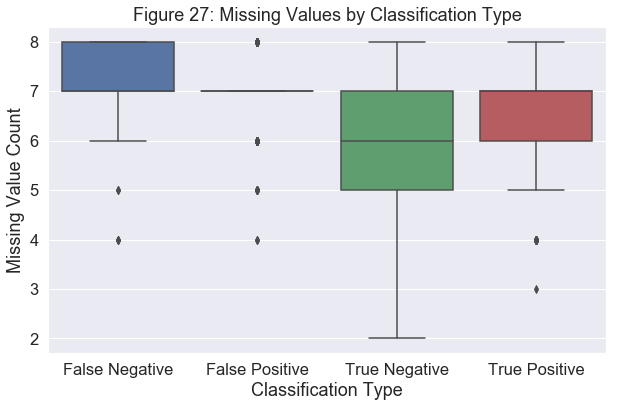

In [70]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 6))

sns.boxplot(x=all_cat_df.loc[:, 'Classification Type'], 
            y=all_cat_df['Null Count'])\
            .set_title('Figure 27: Missing Values by Classification Type')

plt.ylabel('Missing Value Count')

if SAVE_PLOTS: plt.savefig('fig-27-sparsity.png', bbox_inches = "tight")

all_cat_df.groupby('Classification Type')['Null Count'].median()

<h3><center>Conclusions</center></h3>

#### Machine Learning

1. ML can make progress towards resolving EM for online marketplaces.


2. Still, a rather steep trade off persistently exists between recall and precision.


3. Given a perfect-precision requirement, the classifiers and feature representations in this project produced an unacceptably low level of recall



#### Features

1. Attribute-to-attribute comparison approach proved superior to representing sets of attributes as unitary text documents


2. Single-document approach had high dimensionality and low variance explained.



<h3><center> Future Research </center></h3>


1. Deep learning neural networks


2. Distributed representations of words and documents


3.  The correct and incorrect predictions did not appear to be significantly affected by the distribution of the missing values





In [67]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# source: https://stackoverflow.com/a/28073228/4463701